In [6]:
%reload_ext autoreload
%autoreload 2

In this chapter we will **only talk about classification**. Classifiers associate a transformed set of features to a set of classes (a discrete variable)

![class_reg](../images/class_reg.png)

In this notebook we are going to focus on distance based classification method (opposed to decision tree for example wich works with threshold more than actual distances). The goal is to give you some insight on 4 different levels:
- **Best practices** 
- **Intuition on the concepts behind those methods**
- **How to implement them with Scikitlearn**
- **Intuition on the different parameters that your model need but are not trainable (hyperparameters)**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from IPython.display import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import svm


%matplotlib inline

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 8
plt.rc("font", size=14)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

# Distance based classification method
## Table Of Content: <a id='toc'></a>

* [Meet the data](#data)
    * [Multiclass dataset : penguins identification](#data-penguin)
    * [Binary class dataset : breast cancer](#data-cancer)

* [**K-nearest neighbors : introduction to basic routine in ML**](#neighbors)
    * [Toy dataset: KNN concepts and hyperparameters](#KN-concepts)
    * [introduction to metrics and core ML concepts](#ml-core)
        * [a metric to score classification : accuracy](#accuracy)
        * [optimizing a metric : the problems](#metric-pb)
        * [optimizing a metric: the solutions?](#metric-solution)
        * [important considerations: leakage](#metric-leakage)
       
    * [applying all this to the cancer dataset](#knn-cancer)
    * [Exercise KNN](#MC-KN)
    
    
* [**Logistic regression**](#Logistic-regression)
    * [Concepts: what is linear regression and introduction to regularization](#Logistic-regression)
    * [Breast cancer dataset](#LR-hyper)
    * [imbalanced dataset](#imbalanced)    
    * [Logistic regression in Multiclass](#LR-IRIS)
        * [LR on the penguin dataset](#LR-PENGUIN)
    
    
* [**Exercise: predicting 10 year coronary heart disease outcome**](#exercise-heart)
    

* [**Appendices**](#APPENDIX)
    * [**Support Vector Machine**](#SVM)
    * [**Exercise**](#exo)




# Meet the data <a id='data'></a>

During this chapter we will play with two datasets and alternate demonstration and exercises on both.

[Back to the ToC](#toc)

## Multiclass dataset : penguins identification <a id='data-penguin'></a>

This dataset consists in data from 344 penguins grouped in three species :

![penguins](../images/lter_penguins.png)
*Artwork by @allison_horst*

[dataset source](https://allisonhorst.github.io/palmerpenguins/)


Among the columns present in there, we drop the ones, like `StudyID` or `sampleNumber` to keep only columns of potential interest for the task at hand :

In [2]:
df_penguin = pd.read_csv( "../data/horst2020_palmerpenguins_raw.csv" )

kept_columns = [ 'Species',  'Clutch Completion', 'Culmen Length (mm)',
       'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex',
       'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


## keep the nice doodle color code!
penguin_colors = {'Adelie':'#FF8C00',
                  'Chinstrap':"#A020F0",
                  'Gentoo':"#008B8B"}


df_penguin = df_penguin.loc[: , kept_columns ]
# keep only the first word of the species field. We do not need the latin name here
df_penguin.Species = df_penguin.Species.apply(lambda x: x.partition(' ')[0])
df_penguin.head()

Species Clutch Completion  Culmen Length (mm)  Culmen Depth (mm)  \
0  Adelie               Yes                39.1               18.7   
1  Adelie               Yes                39.5               17.4   
2  Adelie               Yes                40.3               18.0   
3  Adelie               Yes                 NaN                NaN   
4  Adelie               Yes                36.7               19.3   

   Flipper Length (mm)  Body Mass (g)     Sex  Delta 15 N (o/oo)  \
0                181.0         3750.0    MALE                NaN   
1                186.0         3800.0  FEMALE            8.94956   
2                195.0         3250.0  FEMALE            8.36821   
3                  NaN            NaN     NaN                NaN   
4                193.0         3450.0  FEMALE            8.76651   

   Delta 13 C (o/oo)  
0                NaN  
1          -24.69454  
2          -25.33302  
3                NaN  
4          -25.32426

The columns correspond to :

* **Species** : the penguin species
* **Clutch Completion** : if the study nest ws observed with a full clutch, i.e., 2 eggs
* **Culmen Length** : length of the dorsal ridge of a bird's bill (millimeters)
* **Culmen Depth** : the depth of the dorsal ridge of a bird's bill (millimeters)
* **Flipper Length** : the length of a bird's flipper (millimeters)
* **Body Mass** : the penguin body mass (grams)
* **Sex** : the sex of the animal
* **Delta 15 N** : measure of the ratio of stable isotopes 15N:14N
* **Delta 13 C** : measure of the ratio of stable isotopes 13C:12C

You can see there are some NAs. Let's throw away samples with Nas (only 20 of them):

In [3]:
K = df_penguin.isnull().sum(axis=1) < 1

df_penguin = df_penguin.loc[K,:]
df_penguin.shape

(324, 9)

In [4]:
df_penguin.Species.value_counts()

Species
Adelie       139
Gentoo       118
Chinstrap     67
Name: count, dtype: int64

In [5]:
## finally, we separate the target variable (Species) from the rest
y_penguin = df_penguin.Species

# here note the usage of pd.get_dummies to one-hot encode categorical data!
X_penguin = pd.get_dummies(df_penguin.drop( columns="Species" ), drop_first=True)

In [6]:
X_penguin

Culmen Length (mm)  Culmen Depth (mm)  Flipper Length (mm)  \
1                  39.5               17.4                186.0   
2                  40.3               18.0                195.0   
4                  36.7               19.3                193.0   
5                  39.3               20.6                190.0   
6                  38.9               17.8                181.0   
..                  ...                ...                  ...   
339                55.8               19.8                207.0   
340                43.5               18.1                202.0   
341                49.6               18.2                193.0   
342                50.8               19.0                210.0   
343                50.2               18.7                198.0   

     Body Mass (g)  Delta 15 N (o/oo)  Delta 13 C (o/oo)  \
1           3800.0            8.94956          -24.69454   
2           3250.0            8.36821          -25.33302   
4           3450.0            8.76651          -25.32426   
5           3650.0            8.66496          -25.29805   
6           3625.0            9.18718          -25.21799   
..             ...                ...                ...   
339         4000.0            9.70465          -24.53494   
340         3400.0            9.37608          -24.40753   
341         3775.0            9.46180          -24.70615   
342         4100.0            9.98044          -24.68741   
343         3775.0            9.39305          -24.25255   

     Clutch Completion_Yes  Sex_MALE  
1                     True     False  
2                     True     False  
4                     True     False  
5                     True      True  
6                    False     False  
..                     ...       ...  
339                   True      True  
340                  False     False  
341                  False      True  
342                   True      True  
343                   True     False  

[324 rows x 8 columns]

We can also look at the structure of the data by plotting the correlation betweeb the features:

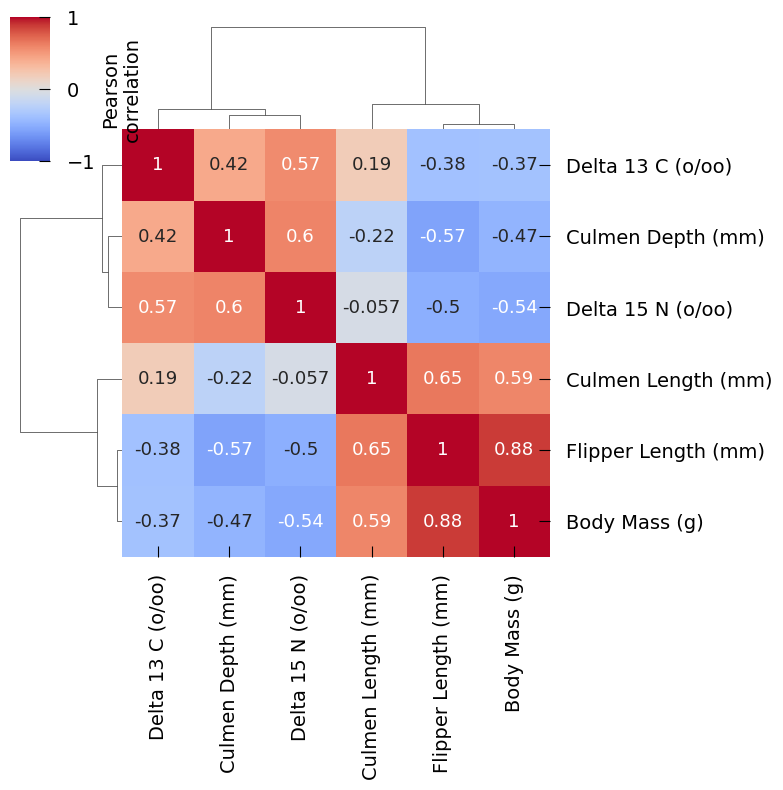

In [7]:
df_penguin_corr = df_penguin.corr(numeric_only=True)

sns.clustermap(df_penguin_corr,
               figsize=(8,8),
               z_score=None,
               row_cluster=True,
               col_cluster=True,
               method='ward',
               cmap='coolwarm',vmax=1,vmin=-1, 
               annot=True, annot_kws={"size": 13},cbar_kws={"label": 'Pearson\ncorrelation'})
## sns allows you to do a hierarchical clustering that simply
plt.show()

The above pearson correlation matrix is highly informational. 

It allows you to see that **some variables are probably redundant** and so you don't need to have all of them, hence reducing the complexity of your model. 

Moreover it is usually bad to have highly correlated variables in your model since it is making it unstable and less interpretable. 

**micro-exercise :** what could we use to handle/mitigate this problem ?

[Back to the ToC](#toc)

## Binary class dataset : breast cancer <a id="data-cancer"></a>

This time, no cute doodle, but maybe that is for the best.

In the cancer dataset you have 569 tumors for which many features have been measured. The goal is to predict if the tumor is malignant or not.

In [8]:
# the breast cancer dataset is integrated in the sklearn library
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

## we reduce the features because otherwise this problem is a bit too easy ;-)
m = list( map( lambda x : x.startswith("mean ") , data["feature_names"] ) )


X_cancer=data['data'][:,m]

# for some reason this dataset has encoded 0 for malignant,
# which is extremely counter intuitive
# So I choose to switch it to the more intuitive order now
y_cancer= 1-data['target']

#making it into a dataframe
df_cancer=pd.DataFrame(X_cancer,
    columns=data["feature_names"][m])

df_cancer["malignant"]=y_cancer

# 0 : benign
# 1 : malignant


df_cancer.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  malignant  
0                 0.07871          1  
1                 0.05667          1  
2                 0.05999          1  
3                 0.09744          1  
4                 0.05883          1

In [9]:
df_cancer.malignant

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: malignant, Length: 569, dtype: int64

In [10]:
print('features:\n')
for s in df_cancer.columns:
    print(s)

features:

mean radius
mean texture
mean perimeter
mean area
mean smoothness
mean compactness
mean concavity
mean concave points
mean symmetry
mean fractal dimension
malignant


In [11]:
df_cancer.malignant.value_counts()

malignant
0    357
1    212
Name: count, dtype: int64

So, there is a slight over-representation of benign tumors.

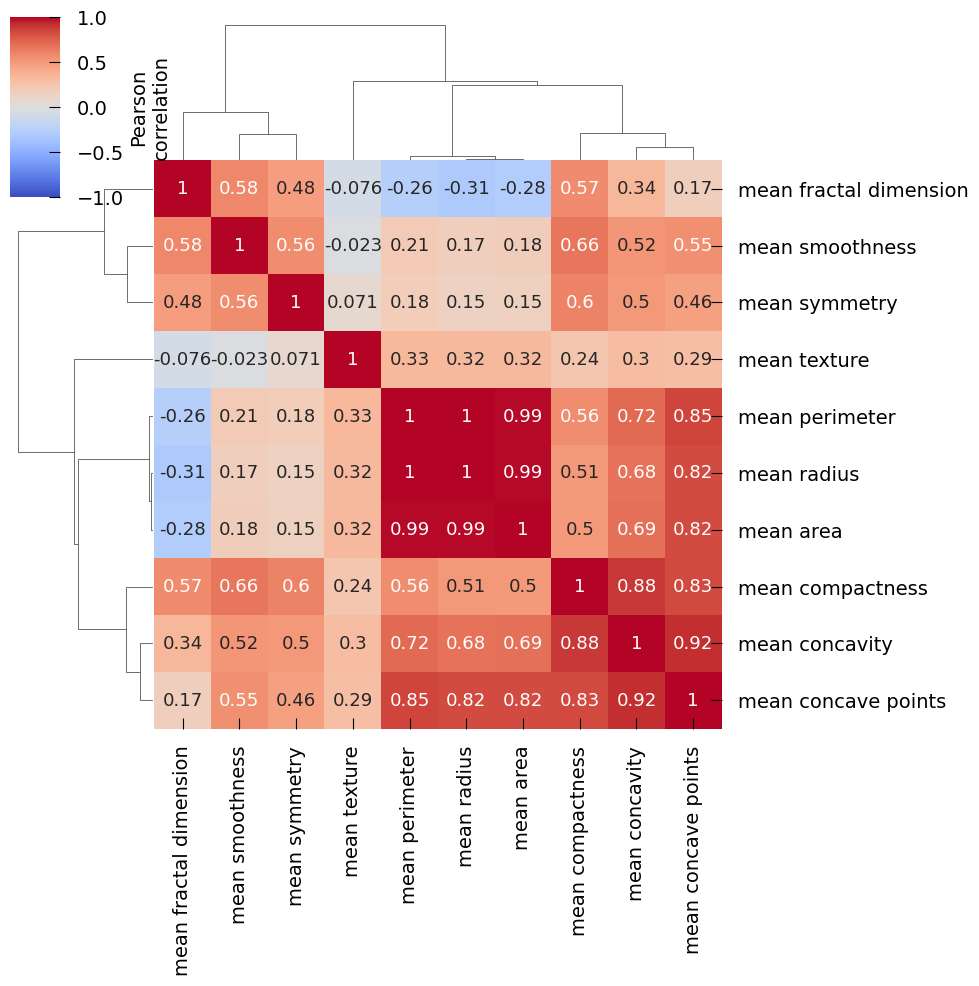

In [12]:
df_cancer_corr = df_cancer[list(df_cancer.columns)[:-1]].corr()

sns.clustermap(df_cancer_corr,figsize=(10,10),z_score=None,row_cluster=True,col_cluster=True,method='ward',cmap='coolwarm',vmax=1,vmin=-1, annot=True, annot_kws={"size": 13},cbar_kws={"label": 'Pearson\ncorrelation'})

plt.show()

[Back to ToC](#toc)

# K-nearest neighbors +  some basic routine <a class="anchor" id="neighbors"></a>

K-nearest neighbors is a pretty simple algorithm in terms of concept but it already has few hyperparameters that you should  understand and try to optimize. It will introduce you to some of the very experimental like routine that machine learning is.

For a classifier, k-nearest neighbors works as follow. 

**First the algorithm simply saves the labels that it is given during the training phase**. 

Then during the testing phase it takes a testing point and checks its `n_neighbors` nearest neighbors. 

**If `n_neighbors` nearest neighbors are mostly (in majority) from one label then the tested point will be assigned this label**. 

The way the `n_neighbors` **nearest neighbors vote** can be either 

 * uniform (every point as the same importance in the vote) or,
 * distance-based (a point distant to the tested point by a distance d will have a weight of 1/d in the vote).

![knn](../images/knn.png)

[Image from datacamp tutorials](https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn)

[Back to the ToC](#toc)

### Toy dataset: KNN concepts and hyperparameters<a class="anchor" id="KN-concepts"></a>

In [13]:
#Let's make some toy dataset. Here using the sklearn function making blobs for you!!!

from sklearn.datasets import make_blobs

# 120 points, 3 blobs/clusters with some spread=3
blob_centers = np.array([[-7,2.5],[6,-10],[8,-3]])
blob_stds = [[1,3],[1,3],[1,3]]
X_3, y_3 = make_blobs(n_samples = 120, 
                      centers = blob_centers,
                      cluster_std = blob_stds, random_state = 42)


#Random_state is here just to be sure that every time you will get the same blobs. 
# If you change the random_state or do not
# specify it then you will get a new plot every time you call the function (random seed)

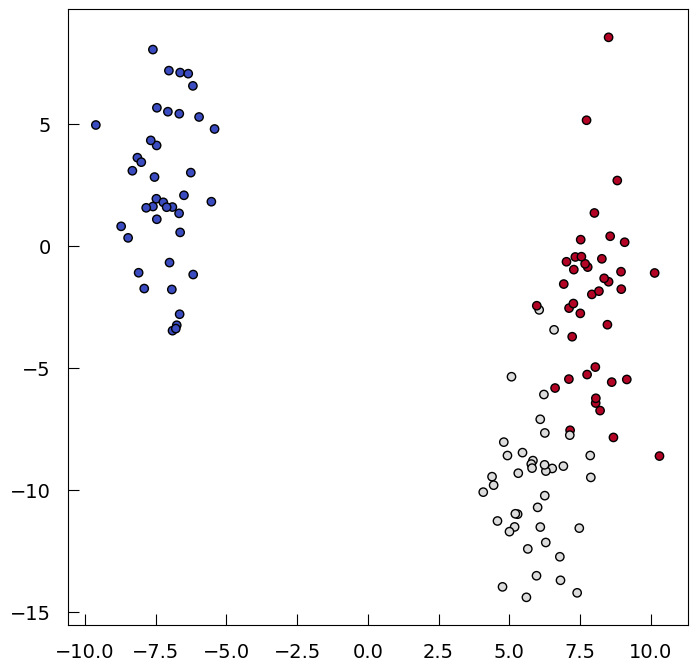

In [14]:
plt.scatter(X_3[:,0],X_3[:,1],c=y_3,cmap=plt.cm.coolwarm,edgecolors='k')
plt.show()

fitting a KNN classifier with sklearn looks like this:

In [15]:
## create classifier
knn = KNeighborsClassifier( n_neighbors= 5 ) ## how many neighbors to consider

## fitting classifier
knn.fit( X_3 , y_3 )

## getting the classes predicted by the classifier:
knn.predict( X_3 )

array([1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 0, 1, 2, 1, 2, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 2, 1, 1, 2, 1, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 0, 2, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 2, 2, 2, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 0,
       2, 0, 2, 2, 0, 2, 1, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 0,
       2, 2, 1, 2, 0, 1, 1, 2, 0, 1, 2, 1, 1, 0, 2, 2, 1, 2, 0, 2, 2, 0,
       0, 0, 0, 1, 2, 2, 2, 1, 1, 2])

In [16]:
## comparing the prediction and the truth:

pd.crosstab( y_3 , knn.predict( X_3 ) , rownames=['truth'] , colnames=['prediction'] )

prediction   0   1   2
truth                 
0           40   0   0
1            0  38   2
2            0   1  39

Let's lookat the effect of the number of neighbors:

<Axes: title={'center': 'K neighbors k=1, uniform'}>

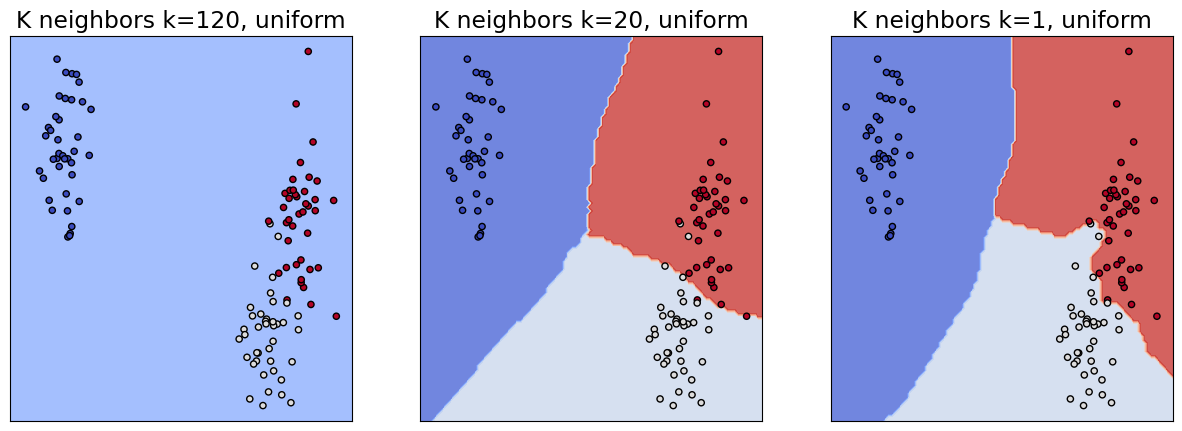

In [17]:
from utils import contour_knn # in utils.py we prepared a number of convenience functions 
fig,axes = plt.subplots(1,3,figsize=(15,5))

## 12 neighbors
contour_knn(120,X_3,y_3,'uniform', ax=axes[0])

## 20 neighbors
contour_knn(20,X_3,y_3,'uniform', ax=axes[1])

## 1 neighbors
contour_knn(1,X_3,y_3,'uniform', ax=axes[2])

In the above we varied the number of voters (neighbors) to decide weither a point is from one class or another. 

You can see how the **boundaries are way more wiggly and attentive to missclassification when the number of neighbors is low**. 

But you can also imagine that if **new data is added it is likely to be missclassified** with those kind of too specific boundaries. 

Conversely, when the number of neighbors is very high (120 here), then the **model is not sensitive to point placement**.

This is a first example of the **bias variance trade off.**

We say that:

 - the model with k=1 has a **high variance**
 - the model with k=120 has a **high bias**


---

Another parameter is **how voting is done**.

Above each of the K nearest neighbors contributed equally to the vote.

By setting `weights='distance'` the contribution of each neighbor will be weighted by the inverse of its distance to the point.

<Axes: title={'center': 'K neighbors k=1, distance'}>

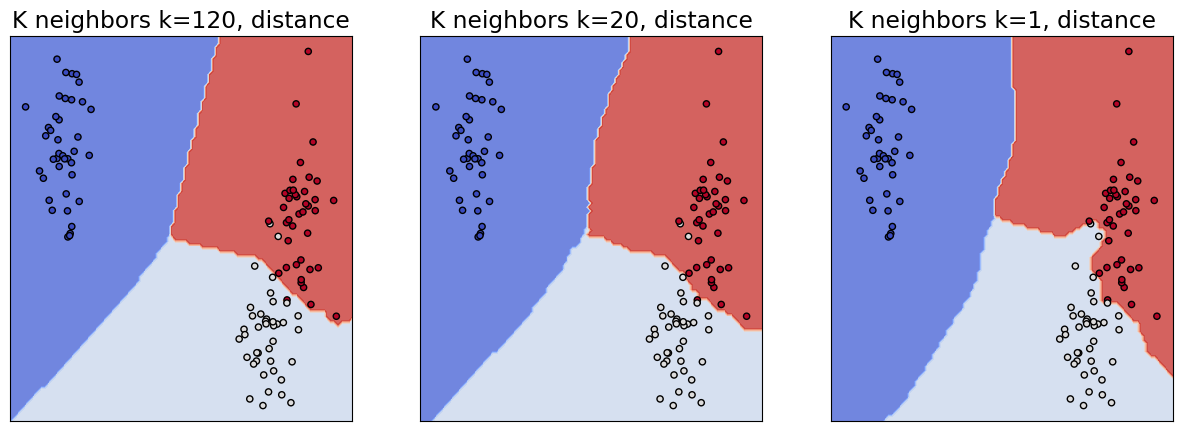

In [18]:
fig,axes = plt.subplots(1,3,figsize=(15,5))

contour_knn(120,X_3,y_3,'distance', ax=axes[0])
contour_knn(20,X_3,y_3,'distance', ax=axes[1])
contour_knn(1,X_3,y_3,'distance', ax=axes[2])

Do you see what changed?

These 2 parameters, K and the weighting, which govern our model bias-variance tradeoff and cannot be set directly from the data are called **hyper-parameters**.

Finding their optimal values is not an easy task, and **strategies for setting hyper-parameters is a big part of Machine Learning**


There are many additional hyper-parameters to consider as well:

 * the imputation strategy
 * the normalization strategy
 * dimensionality reduction : how many PCA axes do I keep?
 * choice of the classification algorithm (KNN, logistic regression, ranfom forest, neural network, ...)
 
 ...
 
 


[Back to the ToC](#toc)

## introduction to metrics and core ML concepts <a class="anchor" id="ml-core"></a>

Here we will see common strategies and concepts used to find good hyper-parameters and be give an honest evaluation of our models.



[Back to the ToC](#toc)


### a metric to score classification : accuracy <a id="accuracy" ></a>

One straight forward metric to evaluate our model is the accuracy. Accuracy is only interesting on the test set, even though it can give you some good insight about your model when accuracy is compared between test and training set. 

But again, the main thing that is going to matter to evaluate your model concern metric evaluated on the test set.


Accuracy is defined as follow : $\frac{TP+TN}{P+N}$

* TP : True Positive
* TN : True Negative
* FP : False Positive
* FN : False Negative
* P : Positive : $P=TP+FN$
* N : Negative : $N=TN+FP$


In [19]:
from sklearn.metrics import accuracy_score

truth = [0,0,0,1,1,1]
pred  = [0,0,1,0,1,1] # 2 errors out of 6 predictions

accuracy_score( truth , pred )

0.6666666666666666

[Back to the ToC](#toc)

### optimizing a metric : the problems  <a id="metric-pb" ></a>

Text(0, 0.5, 'accuracy')

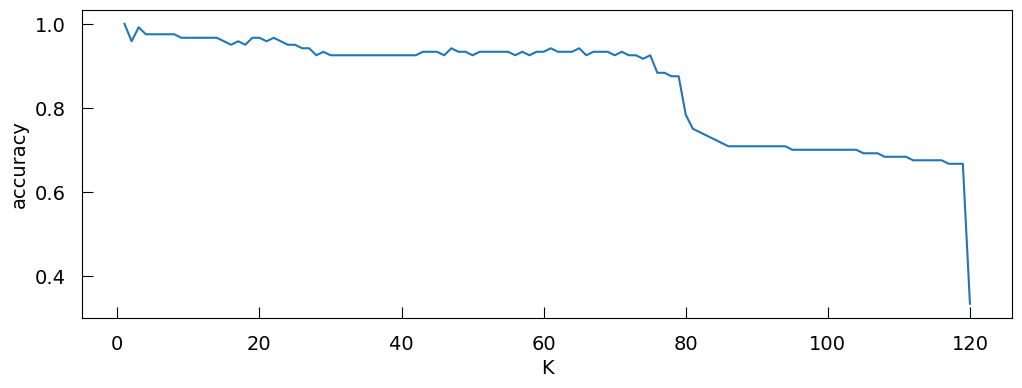

In [20]:
Ks = []
accuracies = []

for k in range(1,len(y_3)+1):
    knn = KNeighborsClassifier(n_neighbors= k, weights= 'uniform' )
    knn.fit( X_3, y_3 )
    
    Ks.append( k )
    
    pred = knn.predict( X_3 )
    accuracies.append( accuracy_score( y_3 , pred ) )

plt.figure(figsize = (12,4))
plt.plot( Ks , accuracies )
plt.xlabel('K')
plt.ylabel('accuracy')

On the very left of the plot the performance is 1.0 on the training data -> overfitting.

On the very right the performance is poor -> under-fitting.

The *good value* of K will likely be in the middle, but where?

You may have heard about the **elbow method** method, where you choose the point on the curve just before where you see drops in performance.

**elbow method moment:** which K would you choose for your model ? 

In [ ]:
K = None ## pick the value of the elbow on the curve above

knn = KNeighborsClassifier( n_neighbors = K )
knn.fit( X_3 , y_3 )
accuracy = accuracy_score( y_3 , knn.predict( X_3 ) )
print(f"chosen K = {K} ; accuracy = {accuracy:.3f}")

So, now we have a model, and we have picked the hyper-parameter K with the elow method.

---

Now, imagine you publish your model or send it your collaborators, and they try your model with their own data:

Text(0.5, 1.0, 'accuracy on our data = 0.925\naccuracy on new data = 0.892')

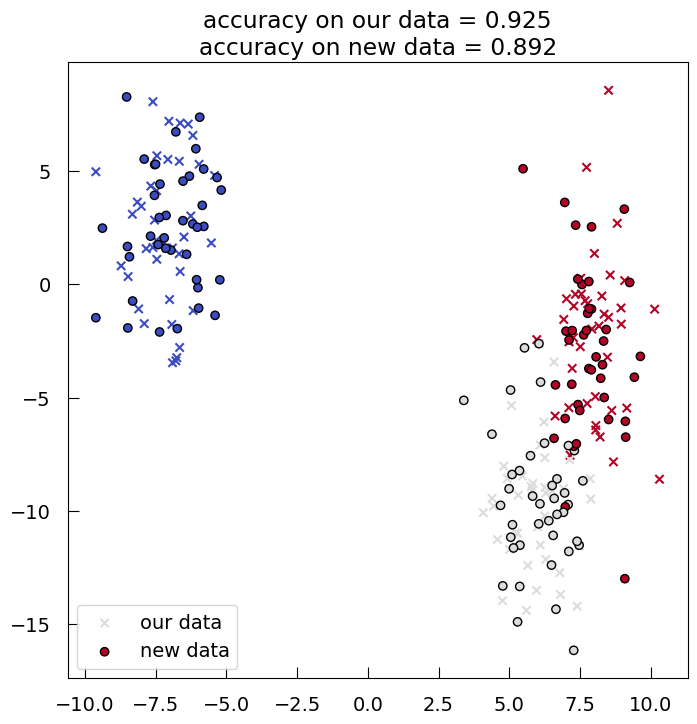

In [22]:
## another team tests your model with their own data:
X_3_new, y_3_new = make_blobs(n_samples = 120, centers = blob_centers,cluster_std = blob_stds, random_state=2024)



plt.scatter(X_3[:,0],X_3[:,1],c=y_3, marker = 'x',cmap=plt.cm.coolwarm , label = 'our data')
plt.scatter(X_3_new[:,0],X_3_new[:,1],c=y_3_new ,cmap=plt.cm.coolwarm,edgecolors='k' , label = 'new data')
plt.legend()


accuracy_new = accuracy_score( y_3_new , knn.predict( X_3_new ) )
plt.title(f"""accuracy on our data = {accuracy:.3f}
accuracy on new data = {accuracy_new:.3f}""")


It looks like the performance of our model is not as good as what we reported.

But, this could be due to bad chance. Let's investigate further:

mean accuracy on independent data : 0.916


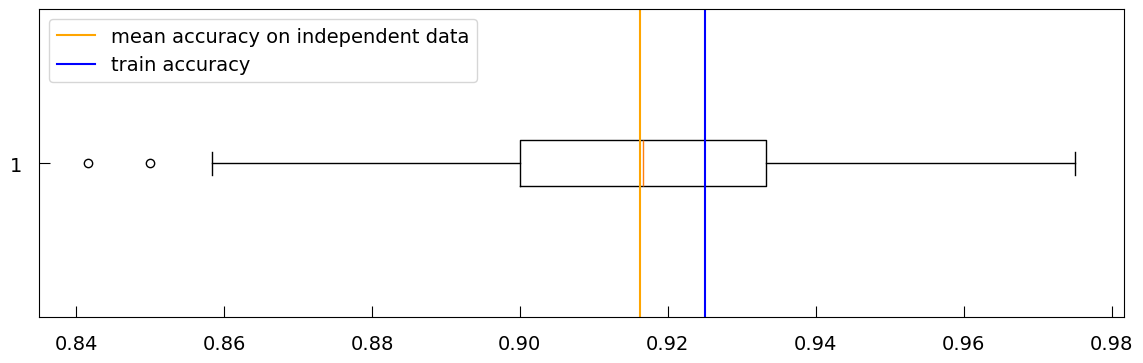

In [23]:
## it could just be bad luck, let's test many independent replications
accuracies_new = []
for i in range(500):
    X_3_new, y_3_new = make_blobs(n_samples = 120, centers = blob_centers,cluster_std = blob_stds)
    accuracies_new.append( accuracy_score( y_3_new , knn.predict( X_3_new ) ) )
    
    
plt.figure(figsize = (14,4))
plt.boxplot( accuracies_new , vert = False  )
plt.axvline( np.mean(accuracies_new) , color ='orange'  , label = 'mean accuracy on independent data')
plt.axvline( accuracy_score( y_3 , knn.predict( X_3 ) )  , color ='blue' , label = 'train accuracy')
plt.legend()
print(f'mean accuracy on independent data : {np.mean(accuracies_new):.3f}')

We see there is a **bias in the accuracy we report**.

In this specific example the bias is not huge, but when left unchecked it takes important proportions and lead to:

 * an overly optimistic view of our results (if we ignore this bias)
 * a general distrust of published results (if we know this bias exists but we don't know how big it is)

Broadly speaking, this sort of mechanics part of the many factors behind the multiple replication crises that have shaken science. 


So now we actually have 2 problems:
 * the elbow method has not really helped us set the value of K reliably
 * we reported an overly optimistic accuracy for our model
 
 
Demonstrating this effect on additional external dataset points us in an interesting direction:
we can **use a dataset independent from the data we trained on to evaluate our model's performance**.

[Back to the ToC](#toc)

### optimizing a metric: the solutions? <a class="anchor" id="metric-solution"></a>


Let's use an independent dataset to determine what would be the best value for K: 

In [28]:
## we anticipate the need for an external dataset
## and we create our own validation dataset
X_3_valid, y_3_valid = make_blobs(n_samples = 120, 
                                  centers = blob_centers,
                                  cluster_std = blob_stds , random_state=654321)


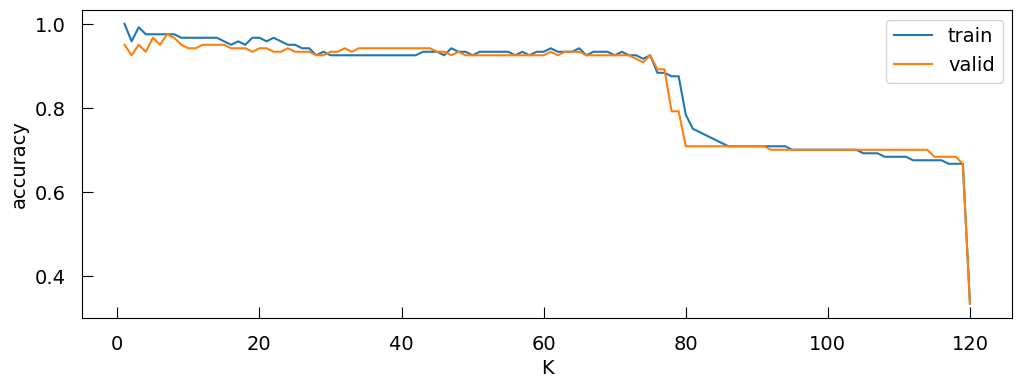

In [29]:
Ks = []
accuracy_train = []
accuracy_valid = []

for k in range(1,len(y_3)+1):
    knn = KNeighborsClassifier(n_neighbors= k, weights= 'uniform' )
    knn.fit( X_3, y_3 )
    
    Ks.append( k )

    pred = knn.predict( X_3 )
    accuracy_train.append( accuracy_score( y_3 , pred ) )
   
    ## now we do the prediction on the validation dataset
    pred = knn.predict( X_3_valid )
    accuracy_valid.append( accuracy_score( y_3_valid , pred ) )

plt.figure(figsize = (12,4))
plt.plot( Ks , accuracy_train , label = 'train')
plt.plot( Ks , accuracy_valid , label = 'valid')
plt.xlabel('K')
plt.ylabel('accuracy')
plt.legend()

In [30]:
i = np.argmax(accuracy_valid)
bestK = Ks[ i ]
bestAccuracyValid = accuracy_valid[ i ]
knn = KNeighborsClassifier( n_neighbors = bestK )
knn.fit( X_3 , y_3 )

print(f"best K = {bestK} ; validation accuracy = {bestAccuracyValid:.3f}")

best K = 7 ; validation accuracy = 0.975


So now we have fixed the value of K, and we have a reported performance on the **validation set**

But let's see if this reported performance is biased:

mean accuracy on independent data : 0.951


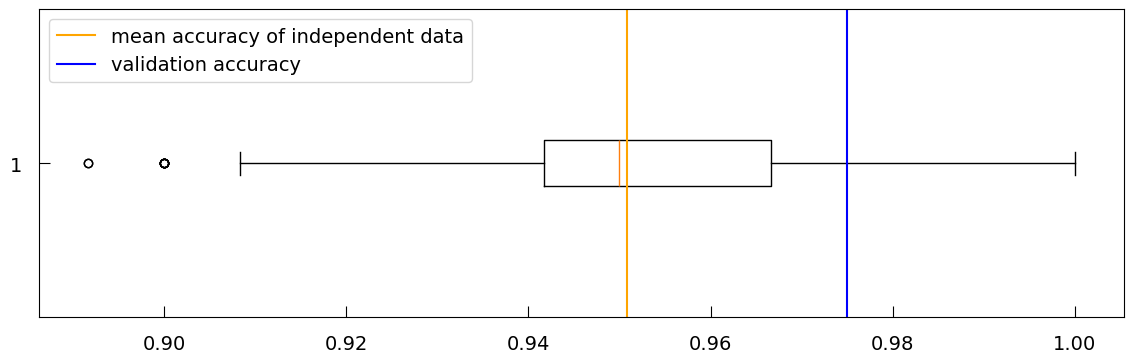

In [31]:

accuracies_new = []
for replicate in range(500):
    X_3_rep, y_3_rep = make_blobs(n_samples = 120, 
                                      centers = blob_centers,
                                      cluster_std = blob_stds)
    
    ## now we do the prediction on the replicate dataset
    pred = knn.predict( X_3_rep )
    accuracies_new.append( accuracy_score( y_3_rep , pred ) )

plt.figure(figsize = (14,4))
plt.boxplot( accuracies_new , vert = False  )
plt.axvline( np.mean(accuracies_new) , color ='orange'  , label = 'mean accuracy of independent data')
plt.axvline( bestAccuracyValid  , color ='blue' , label = 'validation accuracy')
plt.legend()
print(f'mean accuracy on independent data : {np.mean(accuracies_new):.3f}')

So, with the use of validation dataset we have a way to set K to 
 - find a good compromise between over- and under-fitting,
 - be less arbitrary than the elbow plot method


But we can see that we still have some overfit: by optimizing our metric on the validation data **we have now some overfit to the validation set**.


So what do we do?

Basically more of the same:

 1. **optimize** the hyper-parameters on a validation dataset
 2. **evaluate** the final model on yet another independent dataset: the **test set** 

Here, with synthetic data is was easy to create new independent data for this purpose.

In practice, we can rarely do that and so we have to **recursively split our data**

![we split our data in train, validation and test sets](../images/train_test_valid.svg)


--- 
Of course, then comes the question : **"What should be my test-set size?"** 

There is not a single clear-cut answer to this and it depends a lots on the nature of your data and the of the problem you want to solve.


On one hand, if you have **too few training samples**: your model will have a hard time finding the patterns in the data and will likily have poor permance.

On one hand, if you have **too few testing samples**: the evaluation of your model will be very imprecise.

The typical thing you will see around is 80% training / 20% testing, or 75%/25% **BUT**

here are some of things you want to keep in mind :

 * consider the **number of samples** you put in the testing set rather than the proportion
 * you want the test set to be **representative**: how much samples do you need for that?
 * what sort of precision would you like to have on the evaluation of your model?
     You can use [proportion confidence intervals](https://www.statskingdom.com/proportion-confidence-interval-calculator.html) to help you
 * **how hard is your problem?** Some problems need a lot of data, and some needs a lot.
 
You can read more on this subject in this [blog post](https://www.r-bloggers.com/2021/01/what-is-a-good-test-set-size/). 



---




[Back to the ToC](#toc) 

### important considerations: leakage <a class="anchor" id="metric-leakage"></a>

The **test set should never be touched until the last step which is the model evaluation**. 

By doing so we can be confident that our evaluation of the **ability of our model to generalize to new data** is as fair as it can be.

We say that no information coming from the test set should leak into the train set. If this is the case, we are biasing our understanding of the generalizability of our model. 

To avoid **leakage** you should ensure your test set is absent from even the early stages of your pipeline, such as imputation or feature selection (so you have guessed it, most of the operations we have done until now have lead to leakage...).

[Back to the ToC](#toc)

## applying all this to the cancer dataset <a class="anchor" id="knn-cancer"></a>

**We first divide our data into a train and a test set:**


In [32]:
from sklearn.model_selection import train_test_split

#default if 75% training, 25% testing
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, 
                                                                                y_cancer,
                                                                                random_state=7,
                                                                                stratify=y_cancer) 

print("number of samples:")
print( f"\tfull  dataset: {len(y_cancer)}" )
print( f"\ttrain dataset: {len(y_cancer_train)}" )
print( f"\ttest  dataset: {len(y_cancer_test)}" )


# train_test_split stratify make sure to split the data such 
# that the two partitions have similar proportion of each target classes
print("\nproportion of malign cancers:")
print( f"\tfull  dataset: {y_cancer.mean():.3f}" )
print( f"\ttrain dataset: {y_cancer_train.mean():.3f}" )
print( f"\ttest  dataset: {y_cancer_test.mean():.3f}" )



number of samples:
	full  dataset: 569
	train dataset: 426
	test  dataset: 143

proportion of malign cancers:
	full  dataset: 0.373
	train dataset: 0.373
	test  dataset: 0.371


Now, we want leave the test set aside and train a model.

We know that we could use a **validation set to optimize hyper-parameters**.

**BUT** we only have a finite amount of data and further splitting our training set may make it too small for proper learning.

There, we can use a **cross-validation** technique, such as **K-fold cross-validation**



![k-fold validation](../images/kfold.png)


In K-fold CV the training data is split in N (typically 5) parts. between a training and validation set. 

For a specific set of hyperparameter values, we fit as many models as there are parts :
the model is trained on N-1 parts and evaluated on the remaining one.

The average score (e.g. accuracy) from those multiple fitting correspond to the score of this particular set of parameters.

---


We could code all of this ourselves, but sklearn comes with plenty of utilitary classes and function to help us in the very common ML procedure.



- `GridSearchCV` offers a *simple* interface to systematically explore a set of hyper-parameter values while performance cross-validation
- `Pipeline` are scikit way to automatize our successive data-processing steps



In [33]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# create a basic pipeline : just a KNN classification
pipeline_knn=Pipeline([('model',KNeighborsClassifier(n_jobs=-1))])



# define the hyperparameters you want to test
# with the range over which you want it to be tested. 
grid_values = {'model__n_neighbors': np.arange(1,100,1),
               'model__weights':['uniform','distance']}
# the double underscore (__) is used to refer to a step of the pipeline, here the model.



#Feed it to the GridSearchCV with the right
#score over which the decision should be made

grid_knn_acc = GridSearchCV(pipeline_knn, 
                            param_grid = grid_values, 
                            scoring='accuracy',
                            cv= 10 ,    # 10-fold cross validation
                            n_jobs=-1)  # use all available CPUs
 


## now we fit the models 
grid_knn_acc.fit(X_cancer_train, y_cancer_train)

#get the best parameters
print('Grid best parameter (max. accuracy):\n\t ', grid_knn_acc.best_params_)
#get the best score calculated from the training/validation dataset
print('Grid best score (cross-validated accuracy): {:.3f}'.format( grid_knn_acc.best_score_ ) )

Grid best parameter (max. accuracy):
	  {'model__n_neighbors': np.int64(23), 'model__weights': 'distance'}
Grid best score (cross-validated accuracy): 0.908


/home/wandrille/Installed_software/anaconda3/envs/introML2024/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


So there it is: we have applied cross-validation to explore the space of hyper-parameters and we have gotten hyper-parameter values that provide a good bias-variance trade-off.

---

But, before we go to the next part, there is one important thing we forgot in this pipeline: 
like PCA or KMeans, the **KNN algorithm relies on distances** between points.

Meaningful distances can only be computed if all features follow a comparable scale, which is not the case in our cancer dataset:

In [34]:
df_cancer.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  malignant  
0                 0.07871          1  
1                 0.05667          1  
2                 0.05999          1  
3                 0.09744          1  
4                 0.05883          1

So, we will need to add a scaling step to our `Pipeline`.

In [35]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

pipeline_knn=Pipeline([('scale',StandardScaler()), # scaling 
                       ('model',KNeighborsClassifier(n_jobs=-1))]) # KNN


## no new parameters to add for the scaling
grid_values = {'model__n_neighbors': np.arange(1,100,1),
               'model__weights':['uniform','distance']}

grid_knn_acc = GridSearchCV(pipeline_knn, 
                            param_grid = grid_values, 
                            scoring='accuracy',
                            cv= 10 ,            # 10 fold CV
                            n_jobs=-1)          # use all CPUs

## fit the models 
grid_knn_acc.fit(X_cancer_train, y_cancer_train)


print('Grid best parameter (max. accuracy):\n\t ', grid_knn_acc.best_params_)
print('Grid best score (cross-validated accuracy): {:.3f}'.format( grid_knn_acc.best_score_ ) )

Grid best parameter (max. accuracy):
	  {'model__n_neighbors': np.int64(18), 'model__weights': 'uniform'}
Grid best score (cross-validated accuracy): 0.948
CPU times: user 840 ms, sys: 48.6 ms, total: 889 ms
Wall time: 5.72 s


Not only does the model make more sense, but the cross-validated accuracy is better now.


Note that the **proper practice is to include the pre-processing step in the Pipeline**. This:
- prevents you from forgetting to apply it in practice
- let you **explore hyper-parameters** of your preprocessing with the gridSearchCV (eg, nume of PCA axes to keep)
- ensure there is **no leakage from the validation set** during the Cross-Validation



When the number of hyper-parameters is low, we can plot how they influence the score. 

This is also useful to see if there are alternative to our best fit:

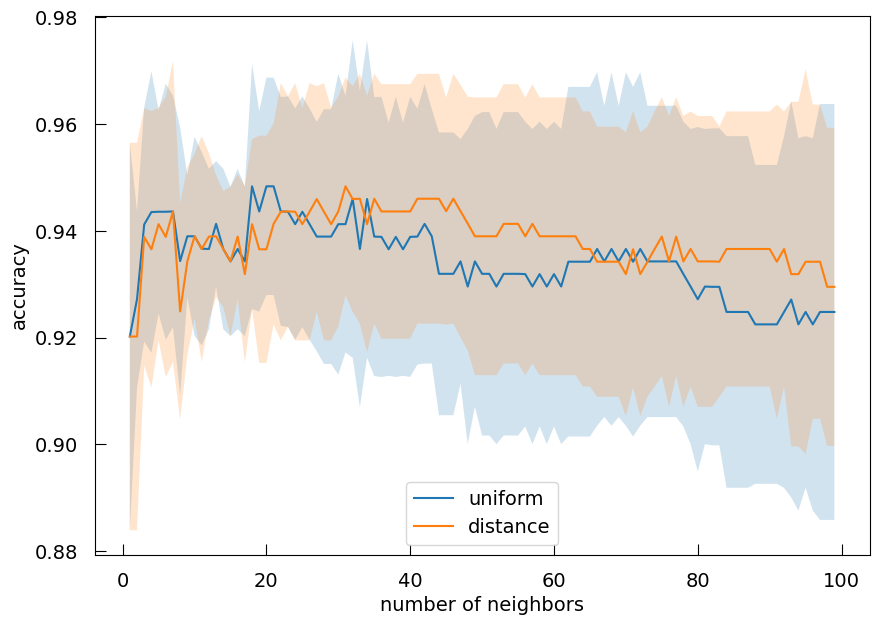

In [36]:
df_res = pd.DataFrame( grid_knn_acc.cv_results_ )
#df_res.loc[:, [ 'param_model__n_neighbors', 'param_model__weights',  'mean_test_score', 'std_test_score' ]]


fig,ax = plt.subplots(1,1,figsize=(10,7))
for W in ['uniform','distance']:
    m = df_res.param_model__weights==W
    ax.plot( df_res.loc[m , 'param_model__n_neighbors'] , df_res.loc[m , 'mean_test_score'] , 
               label = W )
    ax.fill_between( np.array( df_res.loc[m , 'param_model__n_neighbors'] , dtype = int ), 
                       np.array( df_res.loc[m , 'mean_test_score']  - df_res.loc[m , 'std_test_score'] ),
                       np.array( df_res.loc[m , 'mean_test_score']  + df_res.loc[m , 'std_test_score']) , 
                    alpha = 0.2 )
ax.set_xlabel('number of neighbors')
ax.set_ylabel('accuracy')           
ax.legend()    

We see here that a handful of hyperparameter sets have displayed the same cross-validated performance.

The common practice in this case is to use the least complex of the sets, which here corresponds to what the gridSearchCV object proposes.

---

Once we have found the best set of hyper-parameters using cross-validation, we can evalutae our final model on the test set.

Grid best parameter (max. accuracy) model on test:  0.951048951048951


Text(0.5, 2.7777777777777732, 'Predicted label')

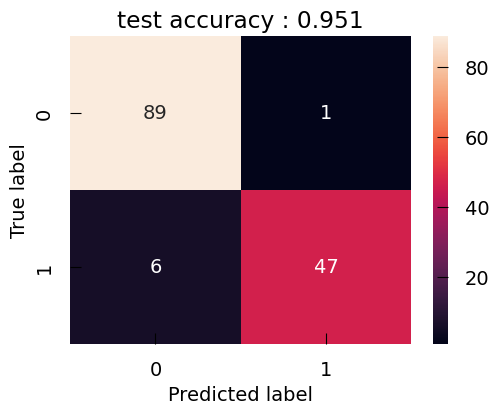

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_test_score=grid_knn_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy) model on test: ', y_test_score)

y_cancer_pred_test = grid_knn_acc.predict(X_cancer_test)

confusion_m_cancer = confusion_matrix(y_cancer_test, y_cancer_pred_test)

plt.figure(figsize=(5.5,4))
sns.heatmap(confusion_m_cancer, annot=True)
plt.title('test {} : {:.3f}'.format( grid_knn_acc.scoring , y_test_score ))
plt.ylabel('True label')
plt.xlabel('Predicted label')

**Congrats!!!! You just trained a classical machine learning model using best practice in term of scaling, hyperparameter choice, and data leakage.**

You just followed the routine that will be ours in this whole course.

In [38]:
## you can access the best model of the grid search with :
grid_knn_acc.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=np.int64(18)))])

Now you might want to save your beautiful model so you can use it later on:

In [39]:
model = grid_knn_acc.best_estimator_

import pickle
pickle.dump(model, open("my_super_model.pickle", 'wb'))

In [40]:
## if you want to load it again

loaded_model = pickle.load(open("my_super_model.pickle", 'rb'))
loaded_model

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=np.int64(18)))])

### A few important points

 * the GridSearch algorithm is a nice algorithm but it is [not the only option for hyper-parameter space exploration](https://scikit-learn.org/stable/modules/grid_search.html)
 * K-fold Cross-Validation is ihnerently stochastic, it is common to [repeat it many times](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html#sklearn.model_selection.RepeatedStratifiedKFold)
 * Accuracy is rarely the most appropriate metric (but more on that later...)


[Back to ToC](#toc)

##  Exercise KNN <a class="anchor" id="MC-KN"></a>

Tune (ie. find the best hyperparameters and train) a KNN model for classifying penguin species.

In [41]:
X_penguin.head()

Culmen Length (mm)  Culmen Depth (mm)  Flipper Length (mm)  Body Mass (g)  \
1                39.5               17.4                186.0         3800.0   
2                40.3               18.0                195.0         3250.0   
4                36.7               19.3                193.0         3450.0   
5                39.3               20.6                190.0         3650.0   
6                38.9               17.8                181.0         3625.0   

   Delta 15 N (o/oo)  Delta 13 C (o/oo)  Clutch Completion_Yes  Sex_MALE  
1            8.94956          -24.69454                   True     False  
2            8.36821          -25.33302                   True     False  
4            8.76651          -25.32426                   True     False  
5            8.66496          -25.29805                   True      True  
6            9.18718          -25.21799                  False     False

In [42]:
y_penguin.value_counts()

Species
Adelie       139
Gentoo       118
Chinstrap     67
Name: count, dtype: int64

In [53]:
# %load -r 1-7 solutions/solution_02_KNN.py
# splitting train and test

In [65]:
# %load -r 7-26 solutions/solution_02_KNN.py
# training the model

In [64]:
# %load -r 27-34 solutions/solution_02_KNN.py
# evaluate the trained model

In [63]:
# %load -r 35- solutions/solution_02_KNN.py
# confusion matrix

[Back to ToC](#toc)

# Logistic regression <a class="anchor" id="Logistic-regression"></a>

**The main hypothesis of logistic regression is that the log odds ratio of the probability that a point is part of a certain class follows a linear combination of the features describing this point.** This is equivalent to the assumption that the two classes are linearly separable and that the log odds ratio increases linearly with the distance from the separating line.

Let's say you only have two classes and so your target variable can only take two values $y_{i} \in\{1,0\}$. Let's define $p(\pmb{x})=P(y=1)$ the probability than your datapoint $\pmb{x}$ belongs to class 1. Let's also say that you have $M$ features to describe a point $\{\pmb{x}_{i}\}_{i=1,...,M}$. And that you have N points.

Then we make the hypothesis that:

$log{\frac{p}{1-p}}=w_{0}+\Sigma^{M}_{i=1}w_{i}x_{i}=w_{0}+\pmb{x}\cdot\pmb{w}$

which translates to

$p(\pmb{x}|y=1)=\frac{1}{1+e^{-(w_{0}+\pmb{x}\cdot\pmb{w})}}$  


![logreg](../images/lr.png)

**So the probability that your datapoint is in class 1 is the logistic function (sigmoid) applied to the linear combination of features.** The larger the weights $\pmb{w}$ the steeper the change between the two classes. The values of $\pmb{w}$ are stored by the 'coeff_' attribute of the [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) class. $w_{0}$ is stored in 'intercept_'. The function 'decision_function($\pmb{x}$)' returns $w_{0}+\pmb{x}\cdot\pmb{w}$ and 'predict_proba($\pmb{x}$)' returns $p(\pmb{x}|y=1)$ and $p(\pmb{x}|y=0)$

Unlike KNN the logistic regression model provides valuable information on the importance of features for the classification. The bigger the absolute value of the weight $w_{i}$ associated with a feature, the more important this feature is to discriminate between your classes (supposed that features are normalized and mapped onto a similar scale).

Fitting a logistic regression model corresponds to optimizing the loss function

$\pmb{w},w_{0}=argmin_{\pmb{w},w_{0}}\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y})$
<br><br>
$\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y})=\Sigma^{N}_{i=1}y_{i}\log(p(\pmb{x}_i|y=1))+(1-y_{i})\log(p(\pmb{x}_i|y=0))$

So, now the way we get the w is from fitting our distribution of probability that a point is in class 1. If the number of features is high and there is a significant amount of non-informative features, the fitting procedure can become unstable. What happens is that some weights of non-informative features may become very large in order to minimize the loss function on the training data, which may lead to reduced performance on the test data (overfitting).

In order to avoid this situation we can add a penalty to the loss function that avoids that weights $w_{i}$ become too large. In ML three such penalties are commonly used:

$\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y}) + \frac{1}{C}\Sigma^{N}_{i=1}|w_{i}|$ , l1 regularization (Lasso) C being the inverse of the weight that you put on that regularization 

$\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y}) + \frac{1}{C}\Sigma^{N}_{i=1}w_{i}^{2}$ , l2 regularization (Ridge) 

$\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y}) + \frac{1}{C}\Sigma^{N}_{i=1}(\alpha|w_{i}|+(1-\alpha)w_{i}^{2})$ , elasticnet

For a deeper understanding of those notions :

 - https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net

 - https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a




* **L1 (lasso)** regularization produces many zero weights.
    It is useful for the case where you suspect that only a few features are informative. 
* **L2 (ridge)** regularization leads to many features with small, but non-zero weights. 


The L1 regularization may have more bias, and the L2 more variance. 

The elasticnet interpolates between these two situations at the cost of having and additional parameter $\alpha$.



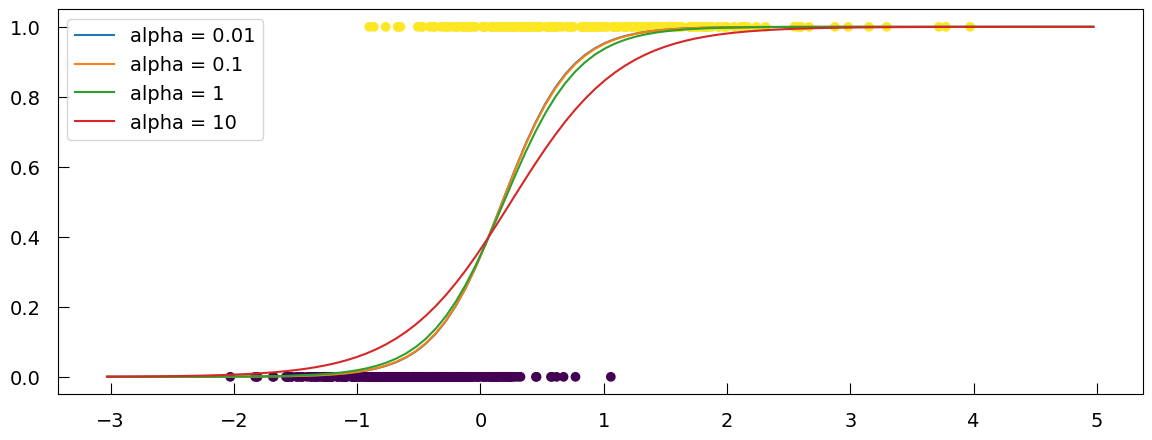

In [43]:
x = np.array( df_cancer.loc[:,['mean radius']] )
x_norm = StandardScaler().fit_transform(x)
y = df_cancer['malignant']

fig,ax = plt.subplots(1,1, figsize = (14,5) )
ax.scatter( x_norm , y , c = y )
for alpha in [0.01,0.1,1,10]:
    
    # this implementation does not take alpha but rather C = 1/alpha
    C = 1/alpha
    lr = LogisticRegression( penalty = 'l2' , C = C  , solver='liblinear')
    lr.fit(x_norm , y)
    
    proba = lr.predict_proba(np.linspace(x_norm.min()-1,x_norm.max()+1,100).reshape(-1, 1))
    ax.plot( np.linspace(x_norm.min()-1,x_norm.max()+1,100) , proba[:,1] , label = 'alpha = {}'.format(alpha) )
ax.legend()

Before we do the fully fledged  GridSearchCV, 
we do a little demo of the **effect of L1 and L2 regularization on model parameters**:

In [44]:
## first we split in train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_cancer_train, 
                                                      y_cancer_train,
                                                      random_state=13245,
                                                      test_size=0.5,
                                                      stratify=y_cancer_train) 

## scaling 
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_valid_norm = scaler.fit_transform(X_valid)



In [57]:
feature_names = list( df_cancer.columns) [:-1]

logCs = []

coef_dict = {'name' : [],
             'val' : [],
             'log_C' : []}
accuracies = []

for C in np.logspace(-3,2,100):

    lr = LogisticRegression( penalty = 'l1' , C = C  , solver='liblinear')
    lr.fit(X_train_norm , y_train)
    
    logCs.append(np.log10(C))
    accuracies.append( accuracy_score( y_valid , lr.predict(X_valid_norm) ) )
    
    coef_dict['name'] += list( feature_names )
    coef_dict['val'] += list( lr.coef_[0] )
    coef_dict['log_C'] += [np.log10(C)]* len(feature_names )

coef_df = pd.DataFrame(coef_dict)

Text(0.5, 0.98, 'logistic regression of cancer data with an L1 regularization.')

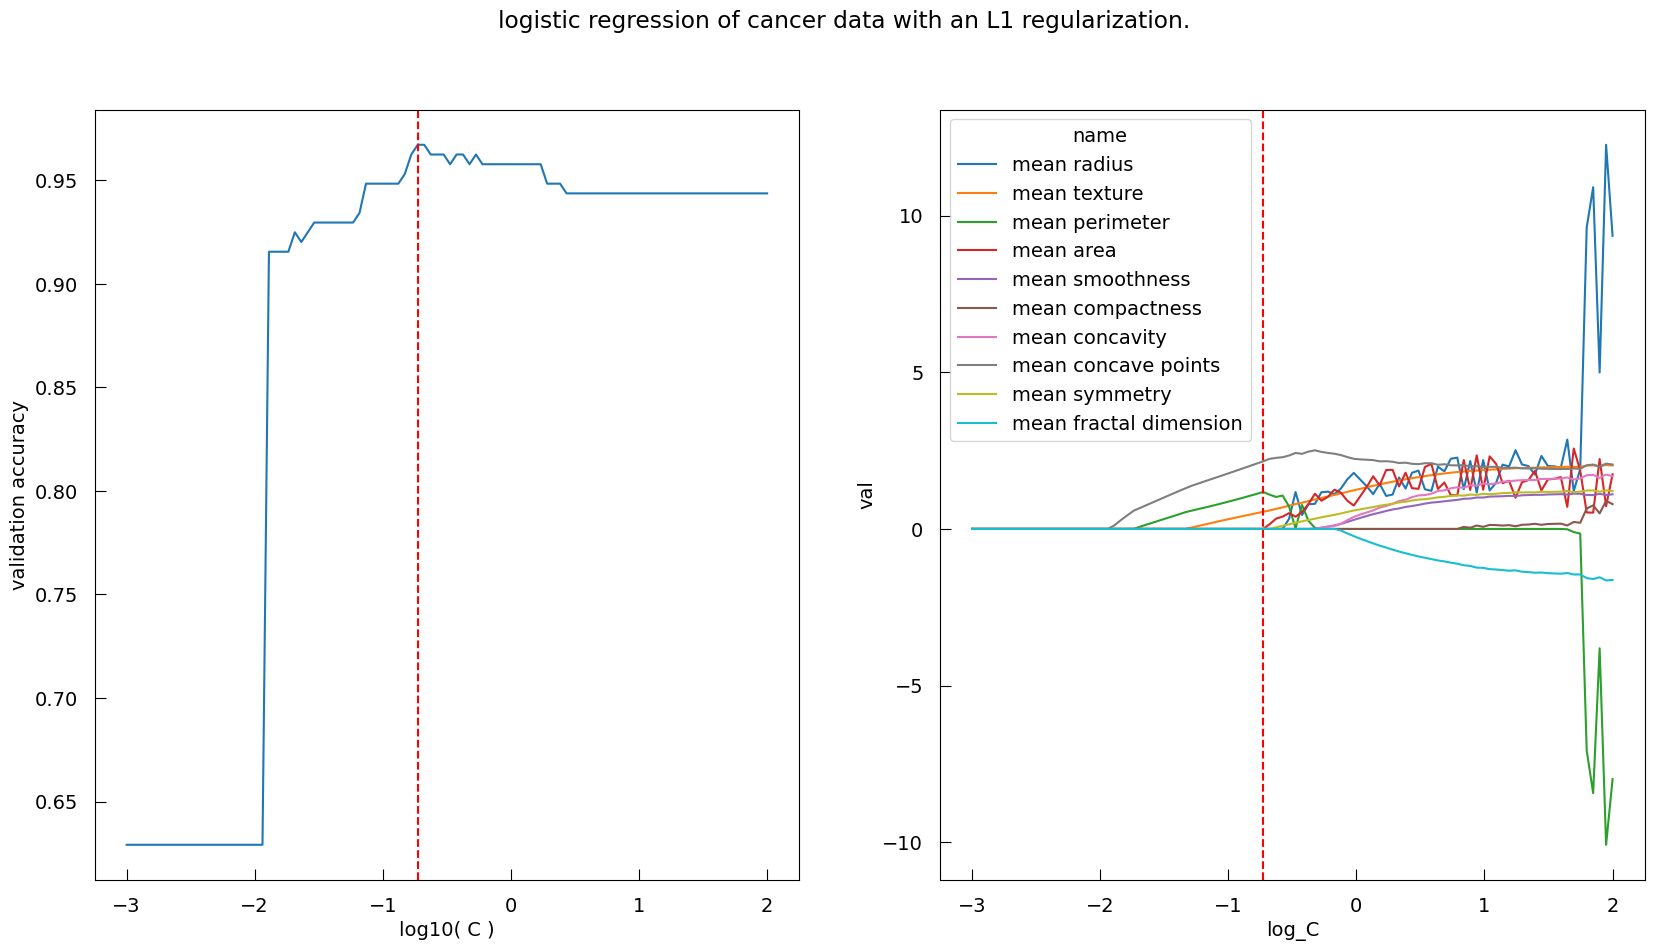

In [58]:
bestC = logCs[ np.argmax( accuracies ) ]

fig,ax = plt.subplots(1,2,figsize = (20,10))

ax[0].plot(logCs , accuracies)
ax[0].set_xlabel("log10( C )")
ax[0].set_ylabel("validation accuracy")
ax[0].axvline( bestC, color='r', ls = '--' )

sns.lineplot( x = 'log_C' , y='val' , hue = 'name' , data= coef_df , ax = ax[1])
ax[1].axvline( bestC , color='r', ls = '--' )

fig.suptitle("logistic regression of cancer data with an L1 regularization.")


**Micro-exercise:** adapt the code above to generate this plot with an **L2** penalty. How do you interpret the difference?

[Back to ToC](#toc)

## logistic regression on the breast cancer dataset  <a class="anchor" id="LR-hyper"></a>

In [59]:
logi_r=LogisticRegression(solver='liblinear',n_jobs=1) 
## the liblinear solver supports both L1 and L2
# for more details see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

pipeline_lr=Pipeline([('scalar',StandardScaler()), 
                      ('model',logi_r)])



grid_values = {'model__C': np.logspace(-5,2,200),
               'model__penalty': ['l1','l2'] }
# define the hyperparameters you want to test
# with the range over which you want it to be tested.


# Feed it to the GridSearchCV with the right
# score(here accuracy) over which the decision should be taken
grid_lr_acc = GridSearchCV(pipeline_lr, 
                           param_grid = grid_values, 
                           scoring='accuracy',
                           cv=10, 
                           n_jobs=-1)


## this cell throws a lot of warning, I remove them with the lines under
grid_lr_acc.fit(X_cancer_train, y_cancer_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        LogisticRegression(n_jobs=1,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'model__C': array([1.00000000e-05, 1.08436597e-05, 1.17584955e-05, 1.27505124e-05,
       1.38262217e-05, 1.49926843e-05, 1.62575567e-05, 1.76291412e-05,
       1.91164408e-05, 2.07292178e-05, 2.24780583e-05, 2.43744415e-...
       2.14614120e+01, 2.32720248e+01, 2.52353917e+01, 2.73644000e+01,
       2.96730241e+01, 3.21764175e+01, 3.48910121e+01, 3.78346262e+01,
       4.10265811e+01, 4.44878283e+01, 4.82410870e+01, 5.23109931e+01,
       5.67242607e+01, 6.15098579e+01, 6.66991966e+01, 7.23263390e+01,
       7.84282206e+01, 8.50448934e+01, 9.22197882e+01, 1.00000000e+02]),
                         'model__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [60]:
print('Grid best parameter (max. accuracy): ', grid_lr_acc.best_params_)#get the best parameters
print('Grid best score (cross-validated accuracy): {:.4f}'.format( grid_lr_acc.best_score_ ) )

Grid best parameter (max. accuracy):  {'model__C': np.float64(0.00032550885998350565), 'model__penalty': 'l2'}
Grid best score (cross-validated accuracy): 0.9483


We could now compare this to the best KNN classifier we obtained

In [61]:
print('Grid best score (cross-validated accuracy): {:.4f}'.format( grid_knn_acc.best_score_ ) )

Grid best score (cross-validated accuracy): 0.9483


It looks like cross-validated performance of both models are very similar here.


Let's check how the logistic regression actually discriminates the two classes with the code below. 

Or said differently : **what can we learn from our model**, apart from pure classification?

In [62]:
from operator import itemgetter
lr = grid_lr_acc.best_estimator_[1]
w=lr.coef_[0]#get the weights

featureW = pd.DataFrame( {'feature':df_cancer.columns[:-1],'weight':w} )

featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance:')
print( featureWsorted.loc[ featureWsorted["weight"] !=0 ] )


Features sorted per importance:
                  feature    weight
7     mean concave points  0.044213
2          mean perimeter  0.042685
0             mean radius  0.042077
3               mean area  0.040313
6          mean concavity  0.039334
5        mean compactness  0.033151
1            mean texture  0.023820
4         mean smoothness  0.019877
8           mean symmetry  0.017417
9  mean fractal dimension -0.002562


<br>

[Back to the ToC](#toc)

<br>

## Imbalanced dataset <a class="anchor" id="imbalanced"></a> 

Let's use the same small example as before, but now instead of 300 sample of each class, imagine we only have 30 of class 1:

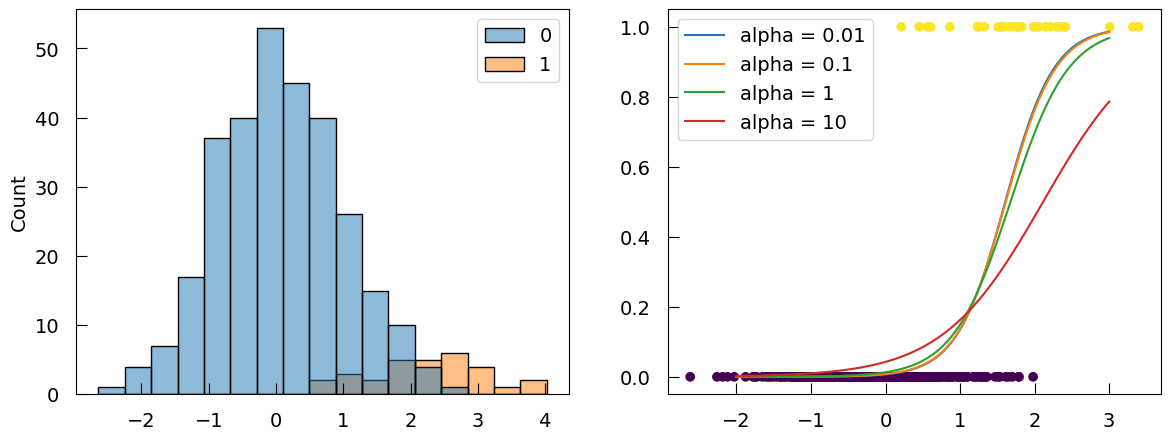

In [63]:
X1 = np.concatenate( [ np.random.randn(300) , np.random.randn(30)+2 ])
y = np.array( [0]*300 + [1]*30 )

# do not forget to scale the data
X1_norm = StandardScaler().fit_transform(X1.reshape( X1.shape[0] , 1 ))

fig,ax = plt.subplots(1,2, figsize = (14,5) )

sns.histplot( x=X1,hue = y , ax =ax [0])


ax[1].scatter( X1_norm , y , c = y )

for alpha in [0.01,0.1,1,10]:
    
    # this implementation does not take alpham but rather C = 1/alpha
    C = 1/alpha
    lr = LogisticRegression( penalty = 'l2' , C = C )
    lr.fit(X1_norm , y)
    
    proba = lr.predict_proba(np.linspace(-2,3,100).reshape(-1, 1))
    ax[1].plot( np.linspace(-2,3,100) , proba[:,1] , label = 'alpha = {}'.format(alpha) )
ax[1].legend()

You can see that now the point where the probability curves for different alpha converge is not 0.5 anymore...

Also, the probability says fairly low even at the right end of the plot.

In [64]:
y_predicted = lr.predict(X1_norm)
print( f"Accuracy with a threshold of 0.5 : {accuracy_score(y,y_predicted):.2f}"  )
pd.crosstab( y , y_predicted )

Accuracy with a threshold of 0.5 : 0.94


col_0    0   1
row_0         
0      300   0
1       20  10

So, most of the class 1 samples are miss-classified (22/30), but we still get a very high accuracy...

That is because, by contruction, both the **logistic regression and accuracy score do not differentiate False Positive and False Negative**.

And the problem gets worse the more imbalance there is :

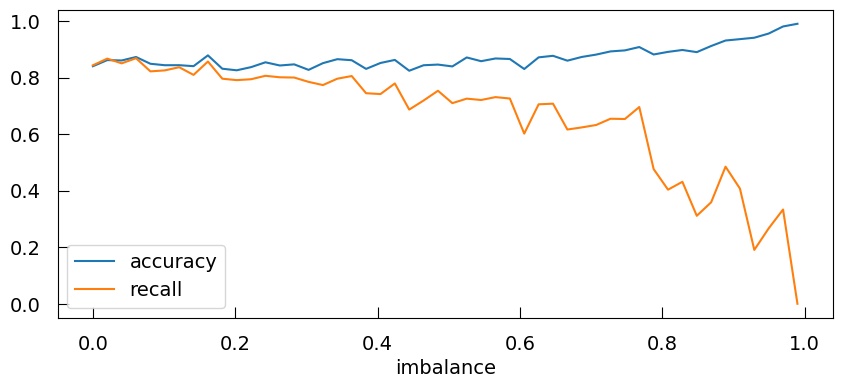

In [66]:
from sklearn.metrics import recall_score

## RECALL = TP / (TP + FN)

recall_list = []
acc_list = []

alpha = 1

## trying many values of imbalance
imbalance_list = np.linspace(0,0.99,50)
for imbalance in imbalance_list:

    ## generating the imbalanced data
    n0 = 300
    n1 = int( n0 * (1 - imbalance) )
    if n1 == 0:
        n1 = 1
    
    X1 = np.concatenate( [ np.random.randn(n0) , np.random.randn(n1)+2 ])
    y = np.array( [0]*n0 + [1]*n1 )

    X1_norm = StandardScaler().fit_transform(X1.reshape( X1.shape[0] , 1 ))
    
    
    ## fitting the logistic regression
    lr = LogisticRegression( penalty = 'l2' , C = 1/alpha )
    lr.fit(X1_norm , y)
    
    y_predicted = lr.predict(X1_norm)

    ## computing accuracy and recall
    recall_list.append( recall_score( y , y_predicted ) )
    acc_list.append( accuracy_score(y,y_predicted) )

        
fig,ax=plt.subplots(figsize = (10,4))
ax.plot( imbalance_list , acc_list , label='accuracy' )
ax.plot( imbalance_list , recall_list , label='recall' )
ax.set_xlabel("imbalance")
ax.legend()

So not only does the precision get worse, the **accuracy actually gets higher as there is more imbalance!**

So the problem here may be 2-fold:
 * imbalance in our dataset skews the **logistic regression** toward a particular outcome
 * **accuracy** is not able to differenciate between False Positive and False Negative, and so it is **blind to imbalance**

Consequently, the solutions will have to come both from the model, and from the metric we are using.


**For the logistic regression**:
 * we will re-weight sample according to their class frequency, so that they are more important during the fitting.
 * in sklearn : `LogisticRegression( ... , class_weight='balanced')`
 
<br> 

**For the metric**, there exists several metrics which are sensitive to imbalance problems. 
Here we will introduce some of the main ones:

- **[balanced accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)**:

$$balanced\_accuracy = 0.5*( \frac{TP}{TP+FN} + \frac{TN}{TN+FP} )$$

- **[average-precision score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score)**: weighted mean of precisions achieved at each recall threshold


Precision : $\frac{\bf{TP}}{\bf{TP}+\bf{FP}}$

Recall : $\frac{\bf{TP}}{\bf{TP}+\bf{FN}}$



<img src="../images/precision_recall_curve.png" alt= "precision-recall curve" width="500px">

- **[ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)**: Area Under the Receiver Operating Characteristic Curve 

<img src="../images/ROC_curve.png" alt= "ROC" width="500px">



In [67]:
from sklearn.metrics import balanced_accuracy_score, recall_score , average_precision_score , roc_auc_score


def check_imbalance_effect( imbalance_list , class_weight = None):
    
    recall_list = []
    balanced_acc_list = []
    acc_list = []
    avg_prec_list = []
    roc_auc_list = []
    
    for imbalance in imbalance_list:

        n0 = 300
        n1 = int( n0 * (1 - imbalance) )
        if n1 == 0:
            n1 = 1

        X1 = np.concatenate( [ np.random.randn(n0) , np.random.randn(n1)+2 ])
        y = np.array( [0]*n0 + [1]*n1 )

        X1_norm = StandardScaler().fit_transform(X1.reshape( X1.shape[0] , 1 ))

        # LR
        lr = LogisticRegression( penalty = 'l2' , C = 1 , class_weight=class_weight)
        lr.fit(X1_norm , y)

        y_predicted = lr.predict(X1_norm)

        recall_list.append( recall_score( y , y_predicted )  )
        acc_list.append( accuracy_score(y,y_predicted) )
        balanced_acc_list.append( balanced_accuracy_score(y,y_predicted) )
        avg_prec_list.append( average_precision_score(y,y_predicted) )
        roc_auc_list.append( roc_auc_score(y,y_predicted) )

    return {'recall':recall_list , 
            'accuracy':acc_list , 
            'balanced_accuracy':balanced_acc_list , 
            'average_precision':avg_prec_list ,
            'ROC_AUC':roc_auc_list}

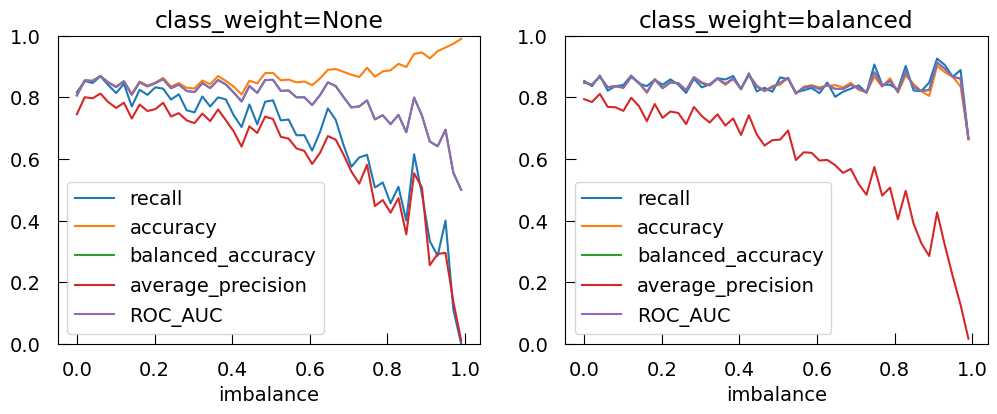

In [68]:
imbalance_list = np.linspace(0,0.99,50)

fig,ax=plt.subplots(1,2,figsize = (12,4))

for i,class_weight in enumerate([None,'balanced']):

    scores = check_imbalance_effect( imbalance_list , class_weight = class_weight)

    for scoreName in scores:
        ax[i].plot( imbalance_list , scores[scoreName] , 
                   label=scoreName )
    ax[i].set_xlabel("imbalance")
    ax[i].set_ylim(0,1)
    ax[i].set_title('class_weight={}'.format(class_weight))
    ax[i].legend()


So, aside from accuracy, the metrics are able to detect an imbalance problem.

Setting `class_weight='balanced'` in our logistic regression fixes the imbalance at the level of the model,
which is reflected in several metrics, except the **average-precision**.

Let's look at that:

imbalance=0.1 recall 0.84	precision 0.85
imbalance=0.5 recall 0.85	precision 0.71
imbalance=0.8 recall 0.90	precision 0.58


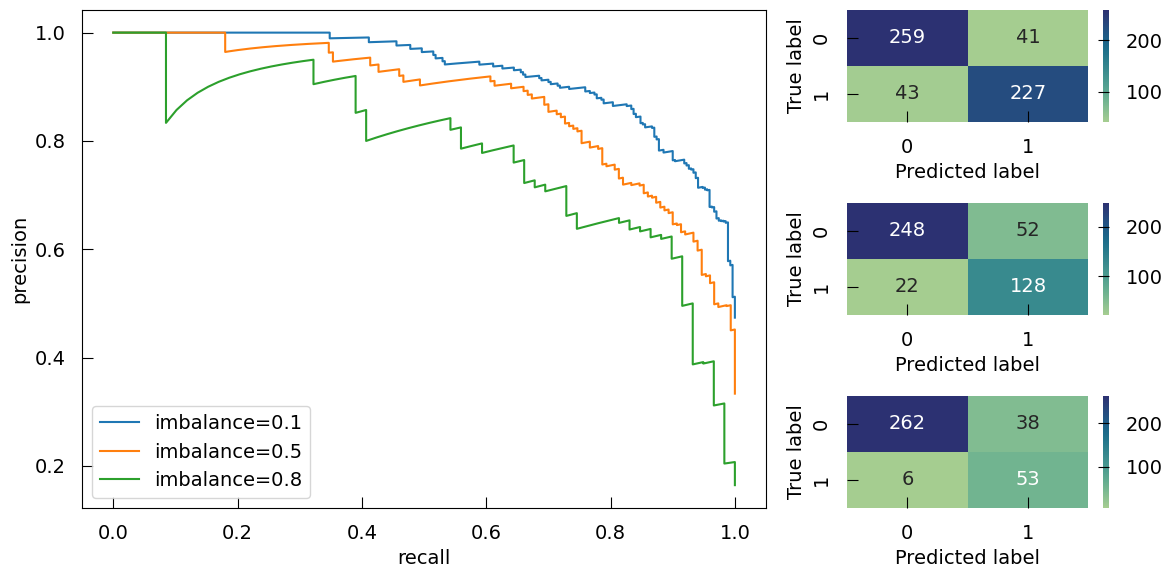

In [69]:
from sklearn.metrics import precision_score
from matplotlib import gridspec

fig=plt.figure(figsize = (12,6))
ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=3)
axes = [ plt.subplot2grid((3, 3), (0, 2)) , plt.subplot2grid((3, 3), (1, 2)) , plt.subplot2grid((3, 3), (2, 2)) ]

for i,imbalance in enumerate( [0.1,0.5,0.8] ) : 

    ## setup 
    n0 , n1 = 300 , max( 1 , int( 300 * (1 - imbalance) ))
    
    X1 = np.concatenate( [ np.random.randn(n0) , np.random.randn(n1)+2 ])
    y = np.array( [0]*n0 + [1]*n1 )
    X1_norm = StandardScaler().fit_transform(X1.reshape( X1.shape[0] , 1 ))

    # LR
    lr = LogisticRegression( penalty = 'l2' , C = 1 , class_weight='balanced')
    lr.fit(X1_norm , y)

    ## precision-recall curve
    y_scores = lr.decision_function(X1_norm)#decision_function gives you the proba for a point to be in
    prec, rec, thre = precision_recall_curve(y, y_scores)
    ax0.plot( rec, prec , label='imbalance={}'.format(imbalance) )    
    
    ## confusion matrix
    y_pred = lr.predict(X1_norm)
    confusion_m = confusion_matrix(y, y_pred)
    sns.heatmap(confusion_m, annot=True , ax = axes[i],fmt='.0f', cmap="crest")

    axes[i].set_ylabel('True label')
    axes[i].set_xlabel('Predicted label')
    
    print('imbalance={}'.format(imbalance) , 
          'recall {:.2f}\tprecision {:.2f}'.format(recall_score(y , y_pred) , precision_score(y , y_pred)) )
ax0.legend()
ax0.set_xlabel('recall')
ax0.set_ylabel('precision')

fig.tight_layout()

So the **average-precision is still sensitive to imbalanced with balanced class weights** because precision **is a ratio across classes: TP and FP**.

In contrasts, the others only use in-labels metrics : TP and FN , TN and FP


In practice, how you handle imbalance should depend on the nature of your data and your problem.

Is the imbalance you see in your data representative of what it will on new data?

Do you care about the type of error you make, or you just want to make as little error as possible ? in the second case, simple accuracy might serve you better

Do you have pre-defined costs associated to different type of errors (eg. [DALY](https://www.who.int/data/gho/indicator-metadata-registry/imr-details/158) of having un-needed surgery vs. DALY of not having needed surgery) ? In that case you may want to use these instead of class frequencies in the balancing and scoring.

---


Let's see concrete example with the immunology data from before:

In [70]:
# load immunology data of notebook 1
df_im = pd.read_csv('../data/aaf2288-Table-S8.csv',header=0)

CD8_info = df_im["CD8+ T cell response induced in healthy donor: Tested/Observed"]
response = np.full(df_im.shape[0],-1)
response[CD8_info.notna() & CD8_info.str.contains("YES /")] = 0
response[CD8_info.notna() & CD8_info.str.contains("/ YES")] = 1

df_im.loc[response==1,'Mutant peptide'] = df_im.loc[response==1,'Mutant peptide']+"*"

# select the numerical features
X_im = df_im[["Position of mutation in peptide","Predicted affinity wildtype peptide (nM)",
              "Predicted affinity mutant peptide (nM)","Predicted cleavage probability wildtype peptide",
              "Predicted cleavage probability mutant peptide","Predicted stability wildtype peptide (hours)",
              "Predicted stability mutant peptide (hours)","% of mutant reads","RNA expression of gene (FPKM)"]]

d = {"Position of mutation in peptide":"MUT_pos",
     "Predicted affinity wildtype peptide (nM)":"WT_affin",
     "Predicted affinity mutant peptide (nM)":"MUT_affin",
     "Predicted cleavage probability wildtype peptide":"WT_cleav",
     "Predicted cleavage probability mutant peptide":"MUT_cleav",
     "Predicted stability wildtype peptide (hours)":"WT_stability",
     "Predicted stability mutant peptide (hours)":"MUT_stability",
     "% of mutant reads":"WT_read_perc",
     "RNA expression of gene (FPKM)":"RNA_expr"}

X_im = X_im.rename(columns = d, inplace = False) # rename the columns
# some features have highly skewed distributions and its better to normalize them by a log-transform
X_im['RNA_expr'] = np.log10(X_im['RNA_expr'])
X_im['WT_affin'] = np.log10(X_im['WT_affin'])
X_im['MUT_affin'] = np.log10(X_im['MUT_affin'])

# select the numerical features

X_im = X_im.set_index(df_im['Mutant peptide'], inplace=False)

X_im = X_im[response>=0]
y_im = response[response>=0]


In [71]:
sc = StandardScaler()
X_im_sc = sc.fit_transform(X_im)
lr_im = LogisticRegression('l2',C=10)
lr_im.fit(X_im_sc, y_im)

#no CV here, which is a bad idea. But here we make an exception since the dataset is very small
# and we are only interested in the effect of the class weight on training
y_pred = lr_im.predict(X_im_sc)

cm = confusion_matrix(y_im, y_pred)

cdf = pd.DataFrame(cm,columns=["negative","positive"],index=["true negative","true positive"])

print( 'accuracy {:.3f}'.format(accuracy_score(y_im,y_pred)))
print("No class weights")
print(cdf)
print("error on the negative category : {:.3f}".format( cm[0,1]/(cm[0,1]+cm[0,0]) ))
print("error on the positive category : {:.3f}".format( cm[1,0]/(cm[1,1]+cm[1,0]) ))

accuracy 0.839
No class weights
               negative  positive
true negative        43         2
true positive         7         4
error on the negative category : 0.044
error on the positive category : 0.636


You can see that the **classifier is very bad at predicting the positive cases** (7/11 wrongly classified!)

**Now, with the  `balanced` option**

In [72]:
from sklearn.metrics import balanced_accuracy_score
lr_im = LogisticRegression('l2',C=10,class_weight='balanced')
lr_im.fit(X_im_sc, y_im)

#no CV here, which is a bad idea. But here we make an exception since the dataset is very small
# and we are only interested in the effect of the class weight on training
y_pred = lr_im.predict(X_im_sc)

cm = confusion_matrix(y_im, y_pred)

cdf = pd.DataFrame(cm,columns=["negative","positive"],index=["true negative","true positive"])

print( 'accuracy {:.3f}'.format(accuracy_score(y_im,y_pred)))
print( 'balanced accuracy {:.3f}'.format(balanced_accuracy_score(y_im,y_pred))) ## the balanced accuracy score also re-weight error by category frequency
print("Balanced class weights")
print(cdf)

print("error on the negative category : {:.3f}".format( cm[0,1]/(cm[0,1]+cm[0,0]) ))
print("error on the positive category : {:.3f}".format( cm[1,0]/(cm[1,1]+cm[1,0]) ))

accuracy 0.821
balanced accuracy 0.820
Balanced class weights
               negative  positive
true negative        37         8
true positive         2         9
error on the negative category : 0.178
error on the positive category : 0.182


Now you can see that the error level is similar for both category

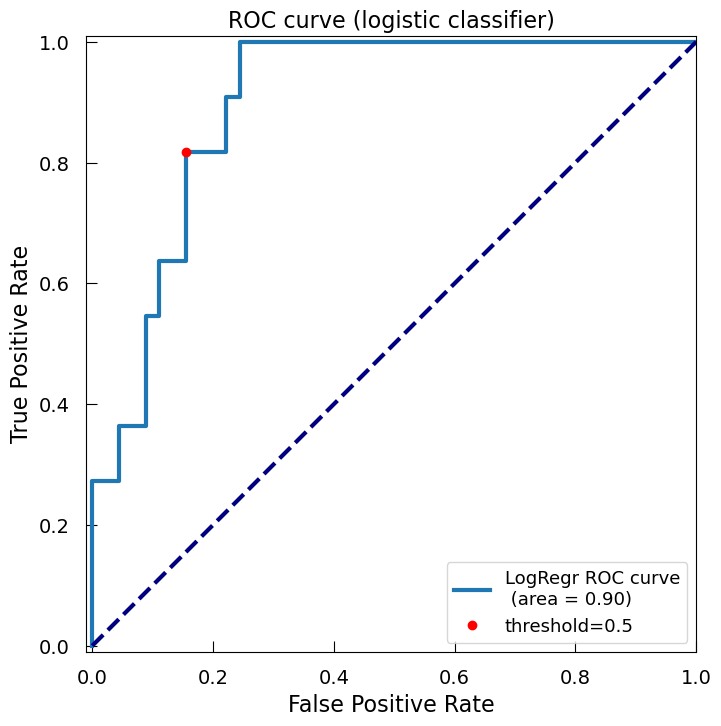

In [73]:
import scipy as sc
# this three lines here are how you get the area under the ROC curve score which is very important for evaluating your model
y_score_im = lr_im.decision_function(X_im_sc)#decision_function gives you the proba for a point to be in
# a class
fpr, tpr, thre = roc_curve(y_im, y_score_im)# this calculates the ROC curve
roc_auc = auc(fpr, tpr)#finally this calculates the area under the curve

## we search for the point which is the closest to the 0.5 probability level (from above)
## change the threshold_level to try out different levels
threshold_level = 0.5
proba=sc.special.expit(thre)
threshold = sum( proba > 0.5 )-1
       

plt.figure(figsize=(8,8))
plt.axes().set_aspect('equal')
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve\n (area = {:0.2f})'.format(roc_auc))
plt.plot(fpr[threshold], tpr[threshold],'ro',label='threshold=0.5')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (logistic classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

From the plot above we see that putting our decision threshold to 0.5 to discriminate between cancer and non cancer lead to missing 2 or 3 % of the cancer. **So maybe a better threshold should be one where you have a TPR of one and a FPR as low as possible.**

**micro-exercise:** On the ROC curve can you find in which direction the threshold is getting bigger?


## micro-exercise: logistic-regression 

Now that you know about imbalance, train a logistic regression classifier on the cancer dataset with an appropriate metric

[Back to ToC](#toc)

## Logistic regression in Multiclass <a class="anchor" id="LR-IRIS"></a>

LR is, originally, really about classifying 0 and 1, so binary.

Of course all of that can still be applied to a multi-class classification, with a little bit of adaptation.

There are many different ways of tackling the problem, which end up being combinations of these 3 elements :

* Either you treat the problem as **one class vs one class** (ie, you re-encode your data)
* Or you treat the problem as a **one class vs the rest** : you subdivide the problem into as many problem as there are classes
* You change your loss function to a multinomial one : softmax intead of a sigmoid.

In any case you need to decide how you are going to **agglomerate those different metrics** (different ROC curves for example):

 * **micro average** : pull all raw numbers together (eg. number of FP, TP), group them and then calculate your overall statistic (eg. TPR)
 * **macro average** : calculate each statistics separately and then do the average.

Think about the differences induced by those metrics. Why should you use one more than the other? Or maybe you should always use all of them?

> Spoiler: is has to do with overall separability and balance between the different class.

Previous versions of scikit-learn gave multiple options regarding how to handle multiclass cases, but now they only use the multinomial implementation. 

Regardless, other methods than the logistic regression still have various option, so it pays to be aware of this issue.


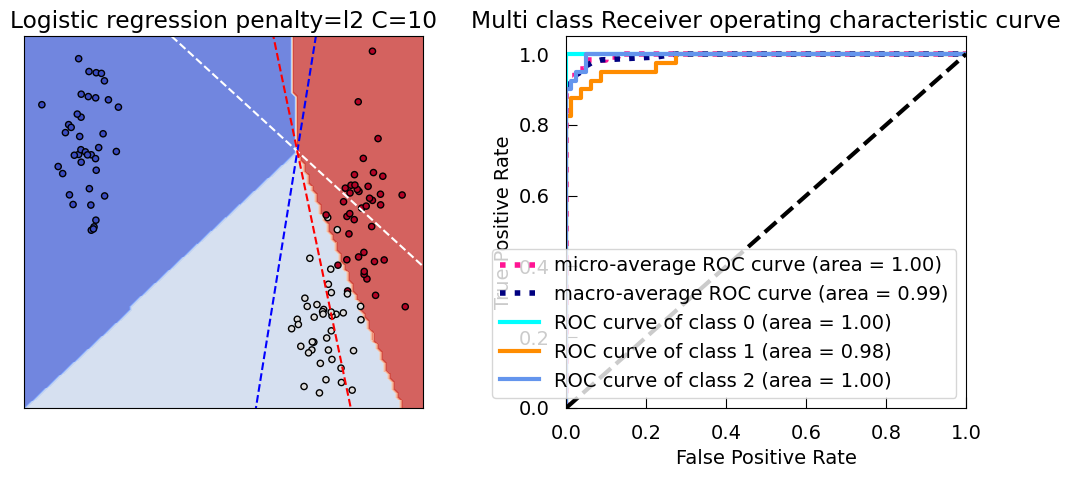

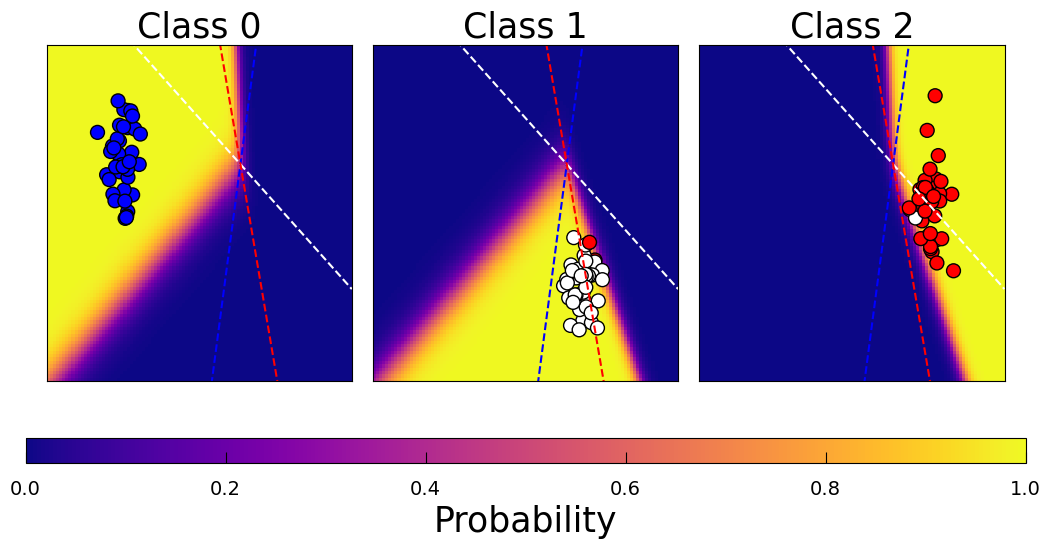

In [74]:
from utils import contour_lr
#multinomial implementation 
contour_lr('l2',X_3,y_3,10)

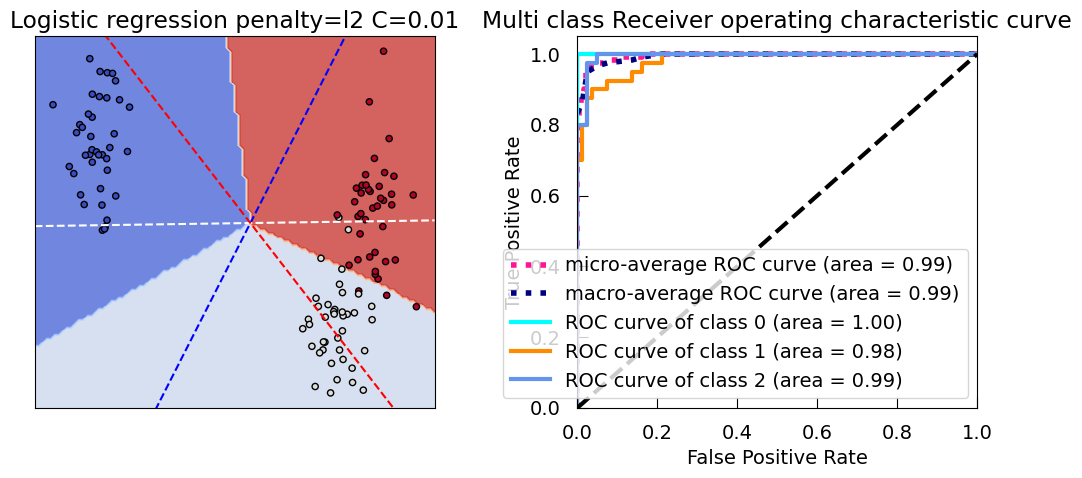

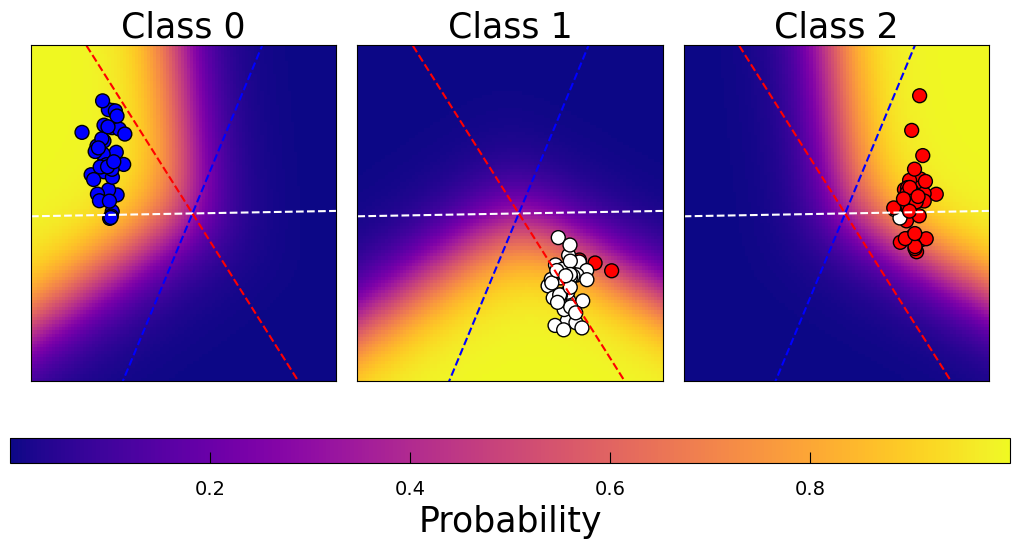

In [75]:
## more regularization
contour_lr('l2',X_3,y_3,10**-2)

Let's apply this to the penguin dataset:

In [76]:
X_penguin_train, X_penguin_test, y_penguin_train, y_penguin_test = train_test_split(
                                                    X_penguin, y_penguin,
                                                    random_state=568132,stratify=y_penguin)

pipeline_lr=Pipeline([('scalar',StandardScaler()),
                     ('model',LogisticRegression(class_weight='balanced'))])

#hyper parameter space :
grid_values = {'model__C': np.logspace(-2,1,50),
               'model__penalty':['l1','l2'],
               'model__solver':['liblinear']}

# note the 'roc_auc_ovr' score!
grid_lr_auc_P = GridSearchCV(pipeline_lr, 
                             param_grid = grid_values, 
                             scoring='roc_auc_ovr_weighted',n_jobs=-1)

grid_lr_auc_P.fit(X_penguin_train, y_penguin_train)

print('Grid best parameter (max. roc_auc_ovr_weighted):')
print( '\t' + '\n\t'.join([str(x) for x in grid_lr_auc_P.best_params_.items()]))
print('Grid best score (roc_auc_ovr_weighted): ', grid_lr_auc_P.best_score_)


Grid best parameter (max. roc_auc_ovr_weighted):
	('model__C', np.float64(0.023299518105153717))
	('model__penalty', 'l2')
	('model__solver', 'liblinear')
Grid best score (roc_auc_ovr_weighted):  1.0


Grid best parameter (max. accuracy) model on test:  1.0


Text(0.5, 2.7777777777777732, 'Predicted label')

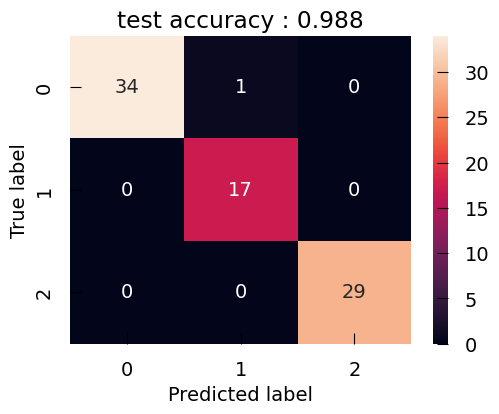

In [78]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_test_score=grid_lr_auc_P.score(X_penguin_test,y_penguin_test)

print('Grid best parameter (max. accuracy) model on test: ', y_test_score)

y_penguin_pred_test = grid_lr_auc_P.predict(X_penguin_test)
testAcc = accuracy_score(y_penguin_test,y_penguin_pred_test)

confusion_m_cancer = confusion_matrix(y_penguin_test, y_penguin_pred_test)

plt.figure(figsize=(5.5,4))
sns.heatmap(confusion_m_cancer, annot=True)
plt.title('test {} : {:.3f}'.format( "accuracy" , testAcc ))
plt.ylabel('True label')
plt.xlabel('Predicted label')

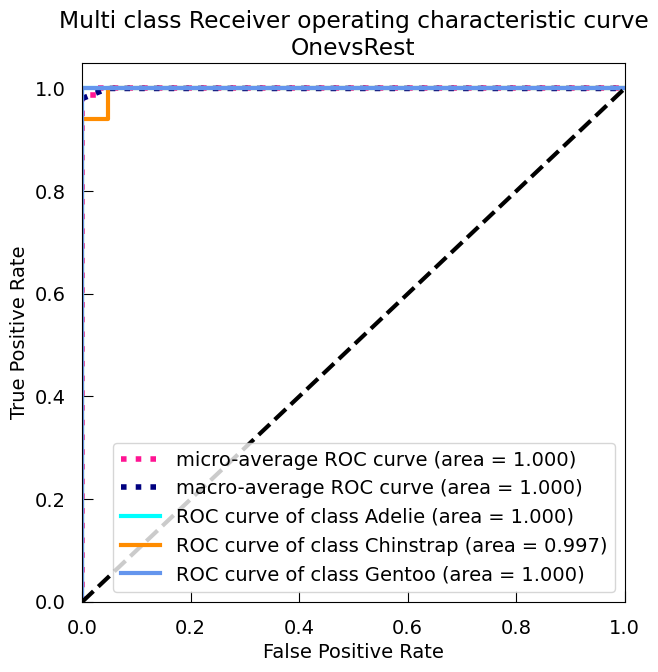

In [79]:
from utils import roc_multi_ovr

roc_multi_ovr(grid_lr_auc_P,3,
              X_penguin_train, 
              y_penguin_train,
              X_penguin_test, y_penguin_test)

In [80]:
## let's extract the model directly from the grid
lr_P = grid_lr_auc_P.best_estimator_['model']

# we get the weights of the fitted model, just for the class 0 : Adelie vs. rest
w=lr_P.coef_[0]

featureW = pd.DataFrame( {'feature': X_penguin.columns,
                        'weight':w} )

# sort them by absolute value
featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance for: Adelie prenguin vs. rest')
featureWsorted.loc[ featureWsorted["weight"] !=0 ]

Features sorted per importance for: Adelie prenguin vs. rest


feature    weight
0     Culmen Length (mm) -0.770998
2    Flipper Length (mm) -0.430684
1      Culmen Depth (mm)  0.413747
5      Delta 13 C (o/oo) -0.296637
3          Body Mass (g) -0.256330
7               Sex_MALE  0.179557
6  Clutch Completion_Yes  0.045069
4      Delta 15 N (o/oo)  0.023763

[Back to ToC](#toc)

# Exercise: predicting 10 year coronary heart disease outcome <a class="anchor" id="exercise-heart"></a>

The [framingham dataset](https://datacatalog.med.nyu.edu/dataset/10046) links some patient features to their risk to develop a heart disease.

In [91]:
df_heart=pd.read_csv('../data/framingham.csv')
print("{} samples - {} features".format(*(df_heart.shape)))
df_heart.head()

4240 samples - 16 features


male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2           0  
3           1  
4           0

In [92]:
##separation in X and y
X_heart = df_heart.drop( columns = "TenYearCHD" )
y_heart = df_heart[ "TenYearCHD" ]



Build and optimize a classifier to predict the column `'TenYearCHD'` (dependent variable : ten year risk of coronary heart disease).
 * use a KNN classifier or Logistic regression, ideally, compare them and choose the best.
 * this dataset has some missing values, decide how you want to handle them.
 * which metric do you want to use here?

***


**Hint :** before, your grid_param was a dictionnary, and it was specific to a particular model since parameters are model dependant. 
To adapt to multiple models, make a list of `grid_params` where each instance of the list is a dictionnary of parameters specific to the model, you want to try.
*Example:*
``` python
grid_param = [
                {"classifier": [KNeighborsClassifier()],
                 "classifier__n_neighbors": np.arange(1,30,1),
                 },
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2','l1'],
                 }]
```

***
This is not an easy problem. **Do not despair if you do not get great performance out of your model, but focus on respecting best practices** (avoid leakage, account for imbalance,...)

***

Solution:

import and minimalist EDA

In [110]:
# %load -r 1-19 solutions/solution_03_heart.py

splitting train and test

In [109]:
# %load -r 20-29 solutions/solution_03_heart.py
## splitting train and test

creating the pipeline and grid, and fitting it

In [108]:
# %load -r 30-55 solutions/solution_03_heart.py
## creating the pipeline and grid, and fitting it

looking at the best model

In [112]:
# %load -r 58-87 solutions/solution_03_heart.py

getting a baseline for understanding the model performance

In [111]:
# %load -r 88-100 solutions/solution_03_heart.py

checking feature importance to learn more about the problem

In [105]:
# %load -r 101-115 solutions/solution_03_heart.py
## checking feature importance to learn more about the problem

[Back to ToC](#toc)


# Appendices <a class="anchor" id="APPENDIX"></a>

# Support Vector Machine (SVM) <a class="anchor" id="SVM"></a>

"The basic principle of SVM is pretty simple. SVM aims at finding the 'good' threshold (hyperplane) to separate data from different classes. Conceptually it is very different from logistic regression where you maximize the log likelihood of the log odds function. **With SVM you really look for an hyperplane that separates data and that's it : there is no underlying hypothesis about probability distribution or anything else. It is very geometrical.**

So what's a good threshold? Again it is going to depend on the metric you are interested in. But at least a good threshold should be linked to this biais variance trade off in the sens that it should offer flexibility to your model.

You can imagine that there is a quite a lot of hyperplanes separating data in your training set. You could stick your threshold right where the class 0 point closest to class 1 lies. But in that case it will be very far from the other class 0 points, which can be a problem. **You could decide that your threshold should be right between the two closest extreme of your classes but that is going to be very sensitive to missclassified data or extreme events... Those points choosen as a reference to put your threshold are called support vectors.**

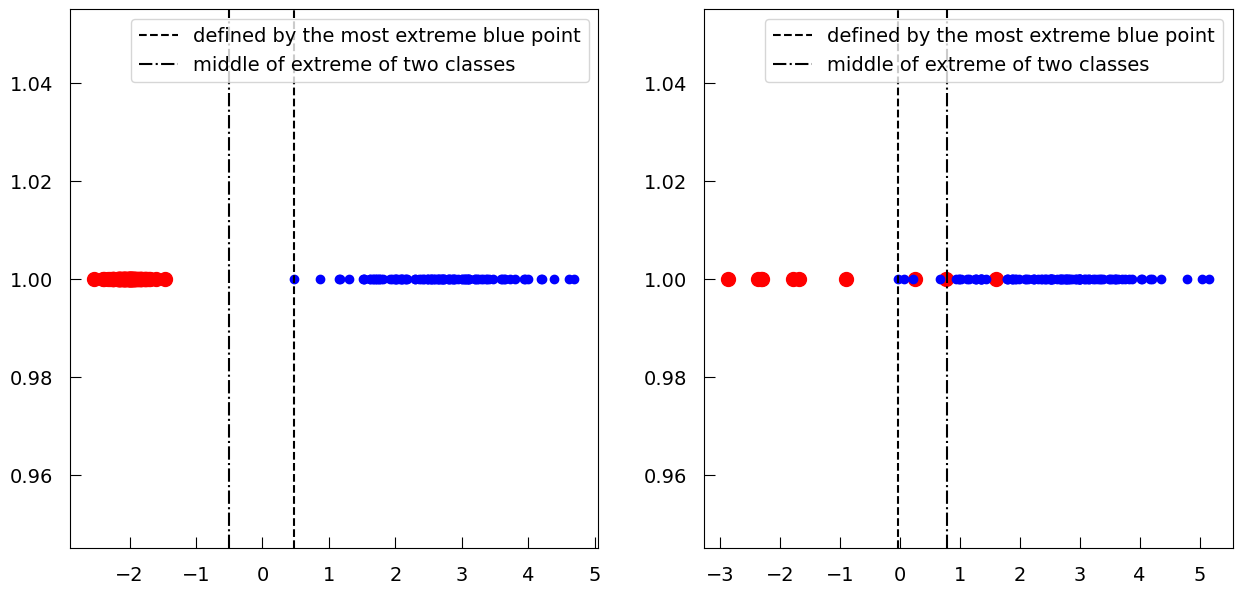

In [117]:
np.random.seed(10815657)
fig,ax = plt.subplots(1,2,figsize=(15,7))

# case 1 
norm1=0.2*np.random.randn(100)-2
norm2=0.8*np.random.randn(100)+2.5

# case 2
cauch=0.8*np.random.standard_cauchy(10)-2
norm=1*np.random.randn(100)+2.5

for i,Ds in enumerate( [ (norm1,norm2) , (cauch,norm) ] ):

    ax[i].plot(Ds[0],[1]*len(Ds[0]),'ro',markersize=10)
    ax[i].plot(Ds[1],[1]*len(Ds[1]),'bo')

    min2 = min( Ds[1] )
    max1 = max( Ds[0] )
    
    ax[i].axvline( min2 , color='k', linestyle='--', label='defined by the most extreme blue point')
    ax[i].axvline( (min2 +max1)/2,color='k',linestyle='-.',label='middle of extreme of two classes')
    ax[i].legend(loc='best')


So, once again, you are confronted to a compromise. You should place your threshold somwhere that is globally best even though that would mean some miss-classification. We are back to our regularization problem and of course **Support vector machine has a regularization parameter : C**. The game now becomes placing your threshold right in the middle of points (support vectors) from  each classes that you have \"chosen\" to be general points for decision making : **they don't need to be the two closest points from different classes anymore. They need to be points where your hyperplane makes the least error differentiating classes.**


![svm_margin](../images/SVM_margin.png)

Image source : image by wikipedia user Larhmam, distributed under a [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/deed.en).


So you want to maximize the margin separating the two classes. This margin is $\frac{2}{||\pmb{w}||}$. So you want to minimize $||\pmb{w}||$. The SVM loss function we want to minimize with respect to $\pmb{w}$ and $b$ is:

$C\cdot\Sigma^{N}_{i=1}\zeta_i + \frac{1}{2}||\pmb{w}||^{2}$ subject to $\zeta_i \ge 0$ and $y_{i}(w^{T}x_{i}-b) \ge 1-\zeta_i$, where $\zeta_i = \Sigma^{N}_{i=1}max(0,1-y_{i}(\pmb{w}\cdot\pmb{x}_i-b))$
 * $y_i$ is $-1$ or $1$ depending on the class of the point $i$
 * the class of point $\pmb{x}$ is determined by the SVM using the sign of $(\pmb{w}\cdot\pmb{x}-b)$ (ie, on which side of the $(\pmb{w}\cdot\pmb{x}-b)$ hyperplane we are).



Note that you could also use a L1 regularization but it is not implemented in the function we are going to use.

Indeed if most of the data points are well separated in term of class on each side of the hyperplane then
* most of the time $y_{k}(w^{T}x_{k}-b) \geq 1$ and so $max(0,1-y_{k}(w^{T}x_{k}-b)=0$ (that's good for minimizing our loss function), 
* and a few times $y_{k}(w^{T}x_{k}-b) \leq -1$ and so $max(0,1-y_{k}(w^{T}x_{k}-b) \geq 2$ (which is polluting our minimization of the loss function).



You can see that there is a [dot product](https://en.wikipedia.org/wiki/Dot_product) involved : in the case of a linear hyperplane this dot product is just the cartesian dot product that you probably use all the time. It allows you to calculate distances between points in that cartesian space or between points and hyperplanes. But you might be familiar with other scalar product : like for example when you proceed to a Fourier decomposition of a function. This particular scalar product acts on functions and so is not really of interest for us... But others exist.

**So in principle you could use other definitions of distance between points to answer that classification question**. This is what non-linear SVM does and this is why you can choose different so called kernels as hyperparameters as we will see below :

$\overrightarrow{x_{i}}.\overrightarrow{x_{j}}$ : cartesian

$(\overrightarrow{x_{i}}.\overrightarrow{x_{j}})^{d}$ : polynomial degree d

$exp(-\gamma||\overrightarrow{x_{i}}-\overrightarrow{x_{j}}||^{2})$ : gaussian radial basis

$tanh(\kappa\overrightarrow{x_{i}}.\overrightarrow{x_{j}}+c)$ : hyperbolic tangent

**This is really powerful for classification but going non-linear by using a kernel trick prevents you from interpreting how your features are massaged to create this classifier... So, if you want interpretability and do science rather than engineering : keep it linear.**


![3d_svm](../images/3d_svm.png)



### Toy data : linear kernel <a class="anchor" id="SVM-linear"></a>

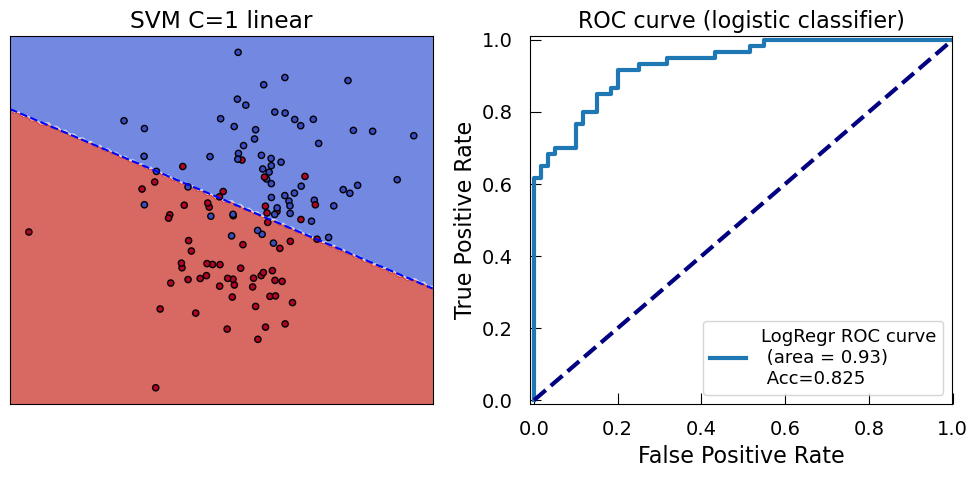

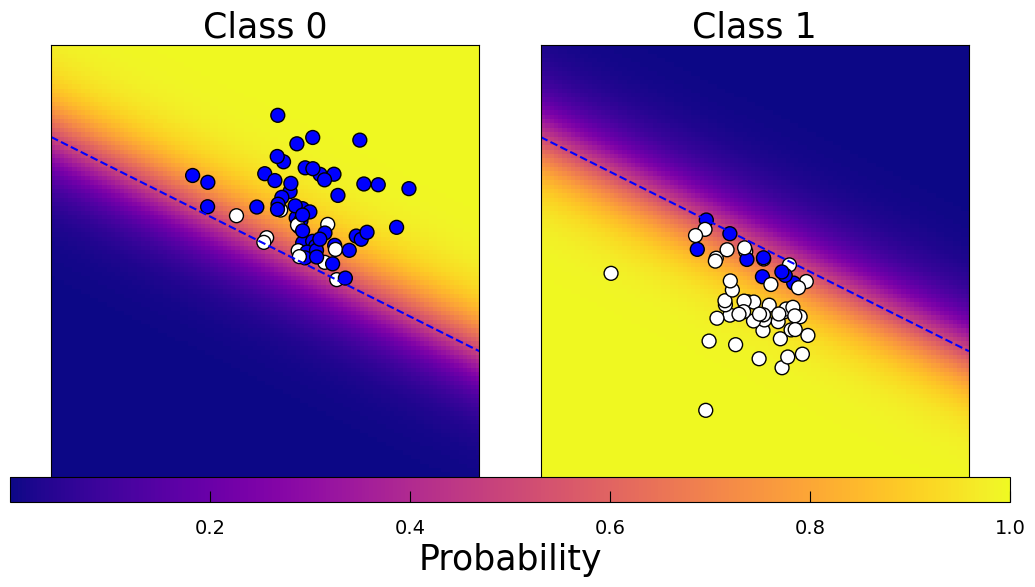

In [118]:
from utils import contour_SVM
from sklearn.datasets import make_blobs
X_toy_2, y_toy_2 = make_blobs(n_samples=120, centers=2,cluster_std=3, random_state=6)

#2 classes
#parameters:X,y,C,kernel,degree for polynomial kernel,gamma for radial kernel,multi class strategy
contour_SVM(X_toy_2,y_toy_2,c=1,ker='linear')

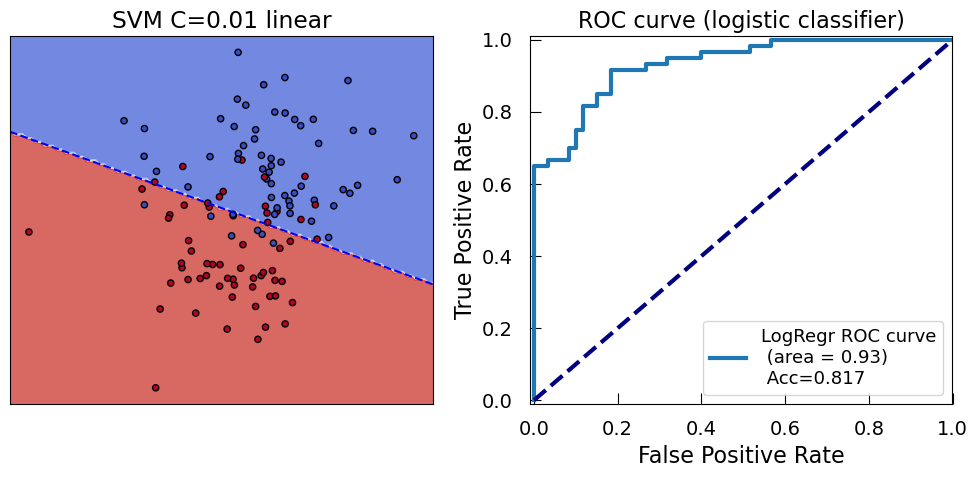

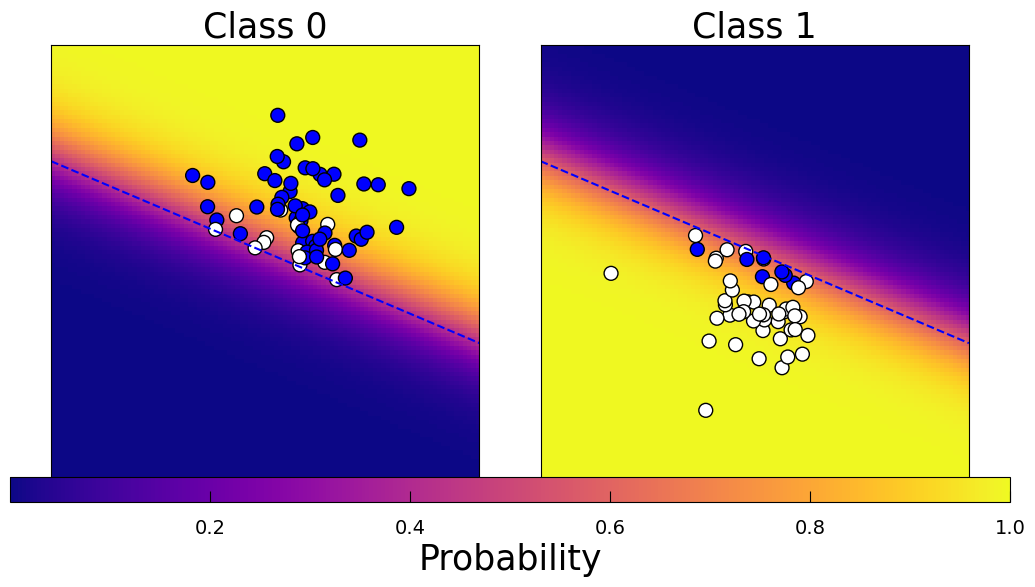

In [119]:
#2 classes
contour_SVM(X_toy_2,y_toy_2,c=0.01,ker='linear')

Reducing C to 0.01 reduces the cost of misclassification and makes the margin larger.

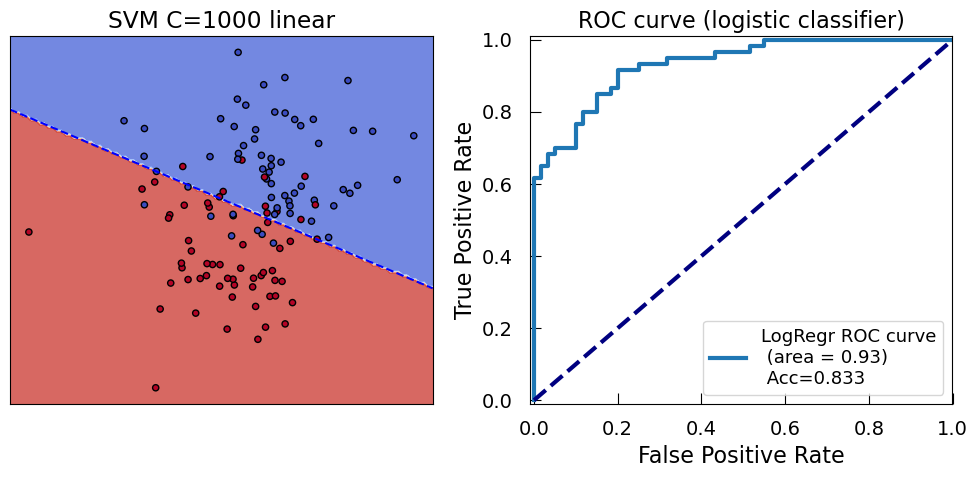

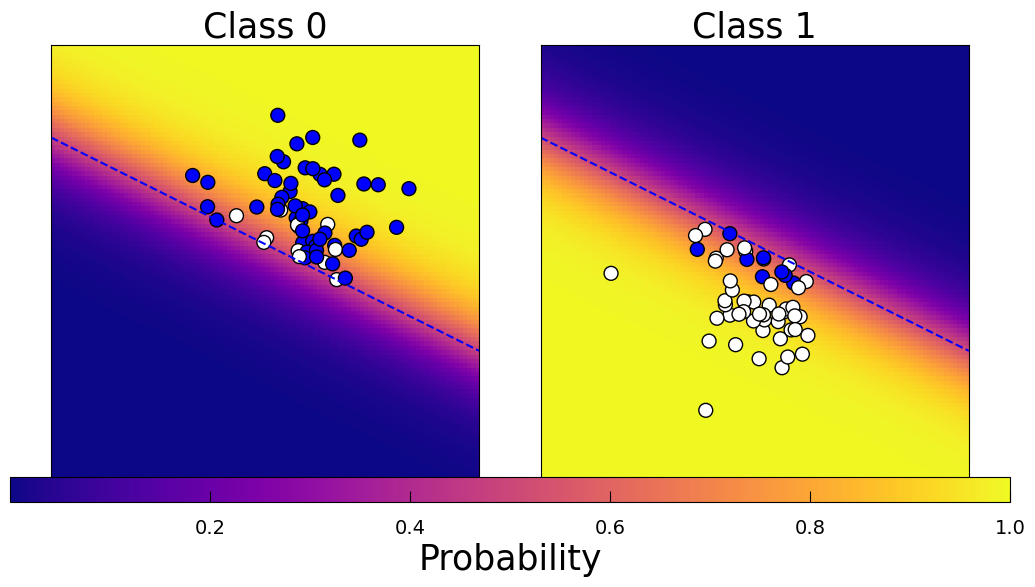

In [120]:
#let's put very little regularization
contour_SVM(X_toy_2,y_toy_2,c=1000,ker='linear')

The inverse is true. Increasing C does not make a big difference to C=1.

### Toy data non linear kernel <a class="anchor" id="SVM-nonlinear"></a>

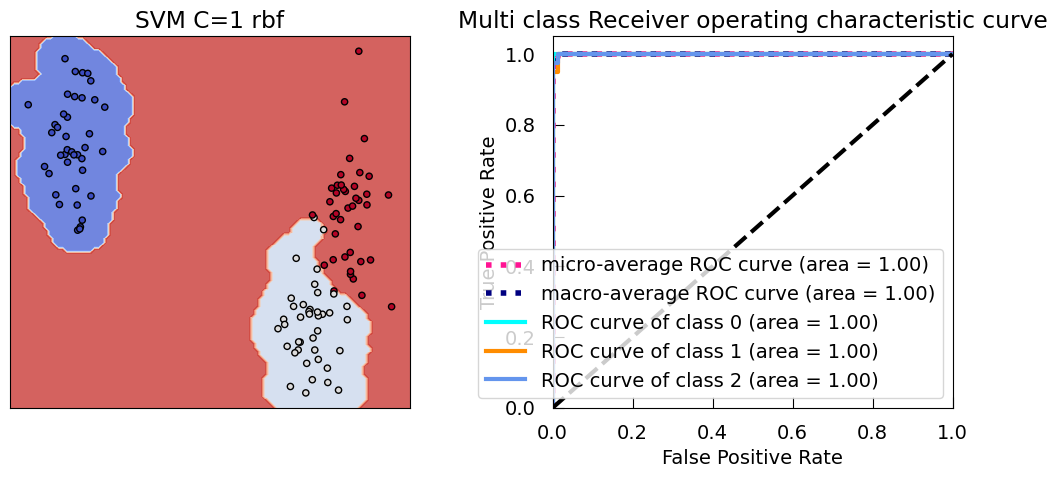

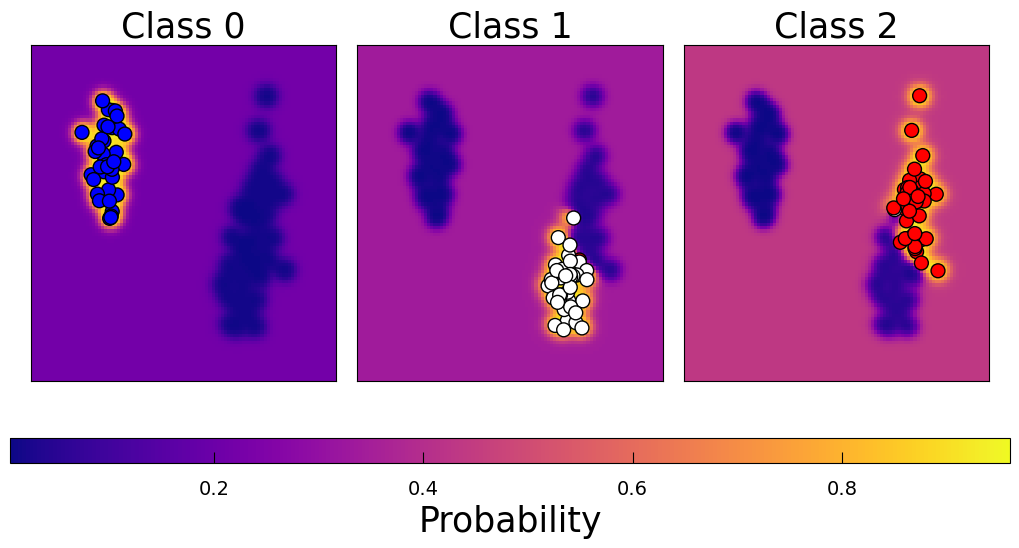

In [121]:
#let's change the scalar product and the notion of distance by using a rbf kernel
#Also we did'nt put much of regularization
#parameters:X,y,C,kernel,degree for polynomial kernel,gamma for radial kernel,multi class strategy
contour_SVM(X_3,y_3,c=1,ker='rbf',gam=1)

In the above example we changed the kernel from linear to Gaussian radial basis. See how the classification boundaries follow local class density levels?

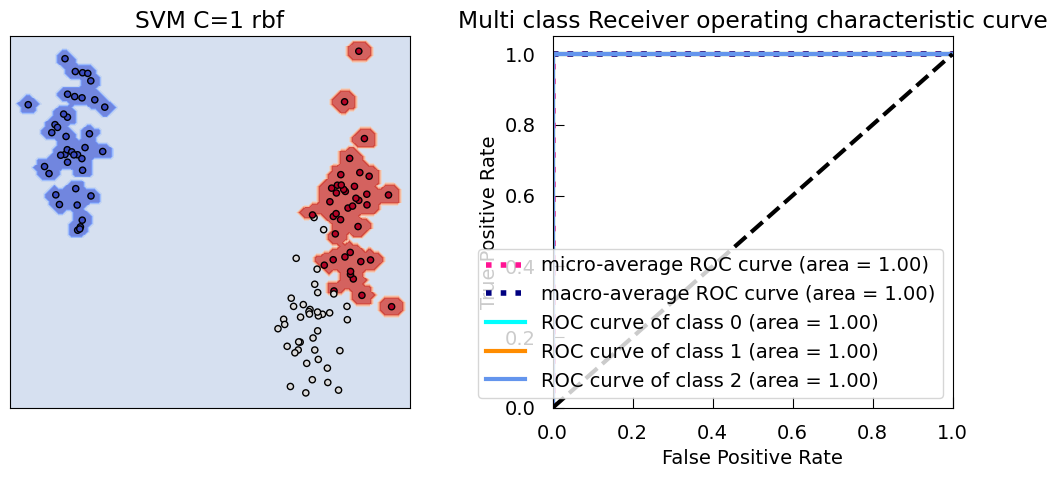

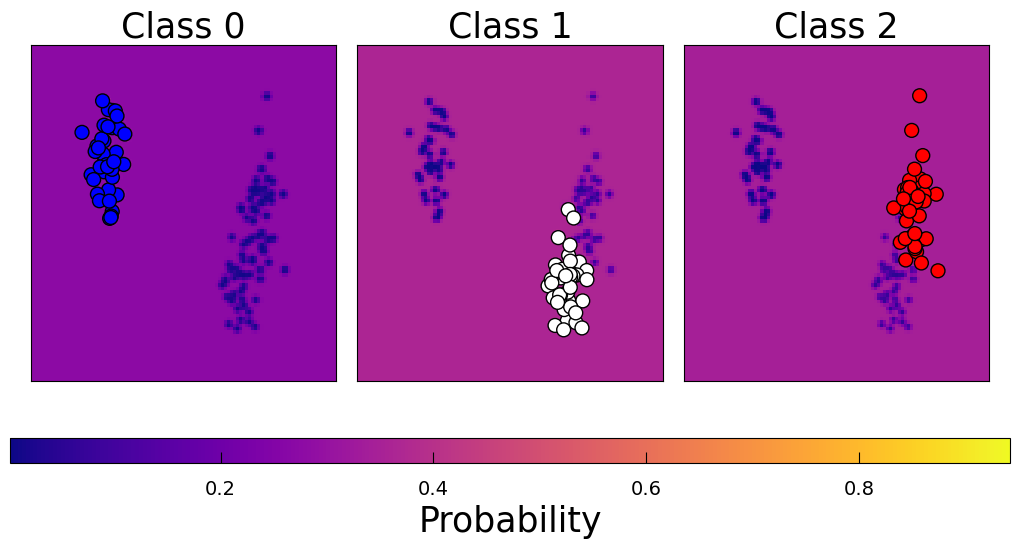

In [122]:
#even less regularization
contour_SVM(X_3,y_3,c=1,ker='rbf',gam=10)

In the above example we greatly reduce the standard deviation on the gaussian model (we increased $\gamma$). See how now the boundaries are really concentrated around each point? 

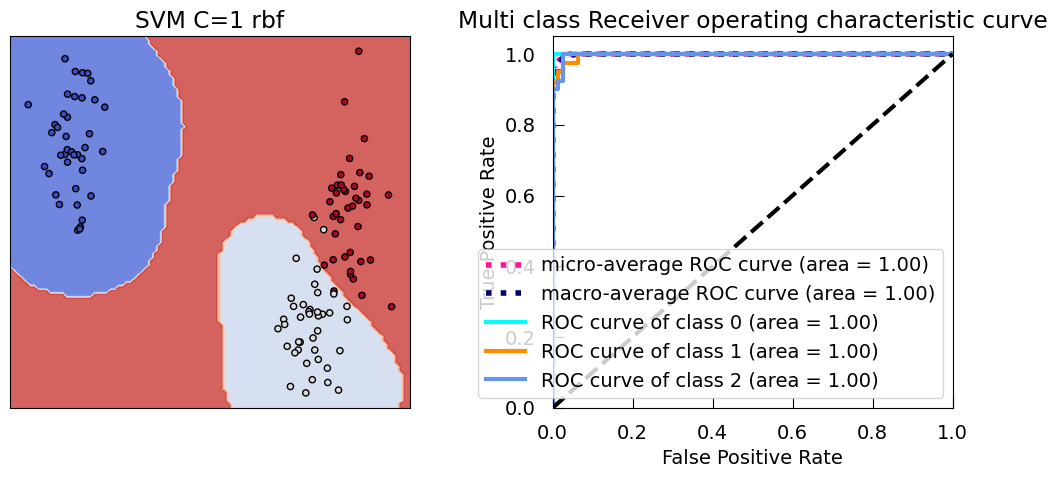

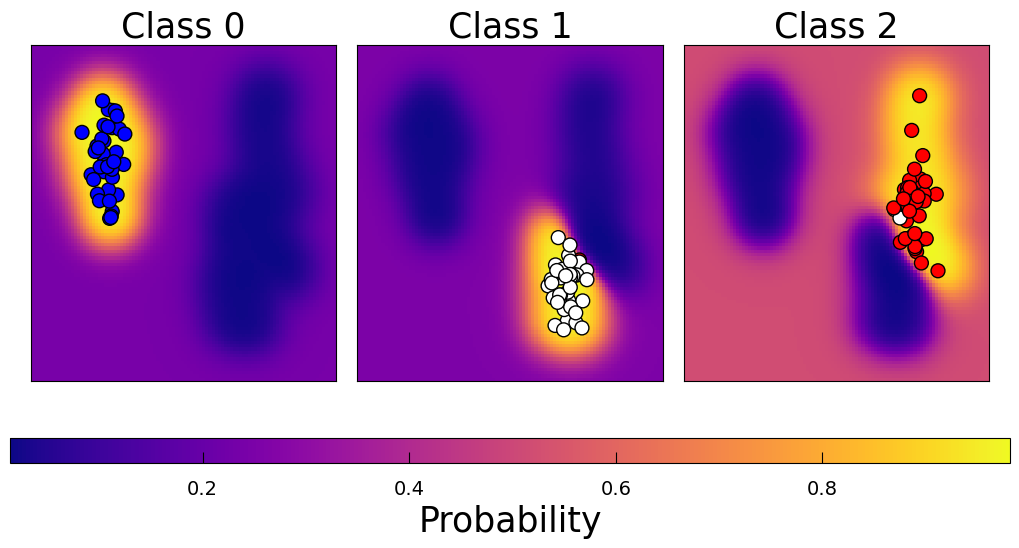

In [123]:
#more regularization
contour_SVM(X_3,y_3,c=1,ker='rbf',gam=0.1)

Inversely by expanding the variance in the gaussian we end up with larger chunks.

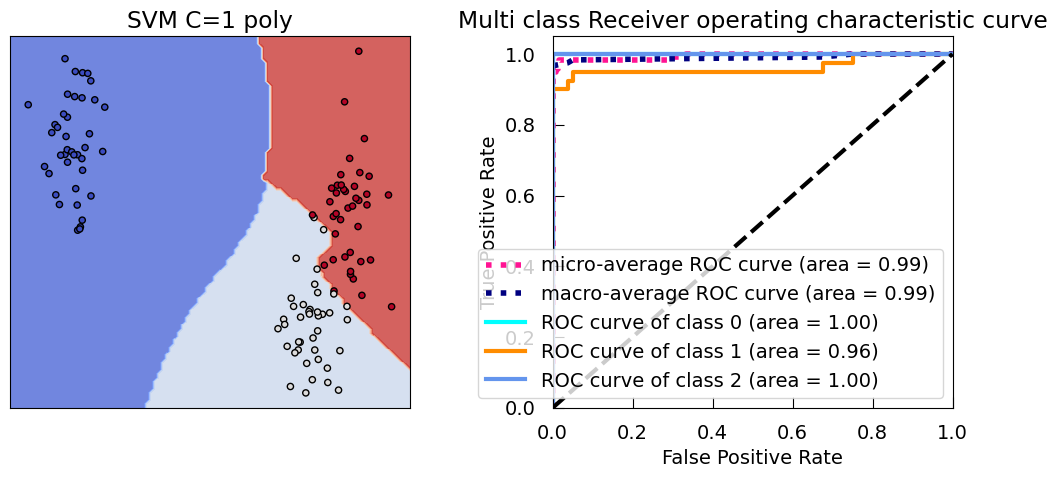

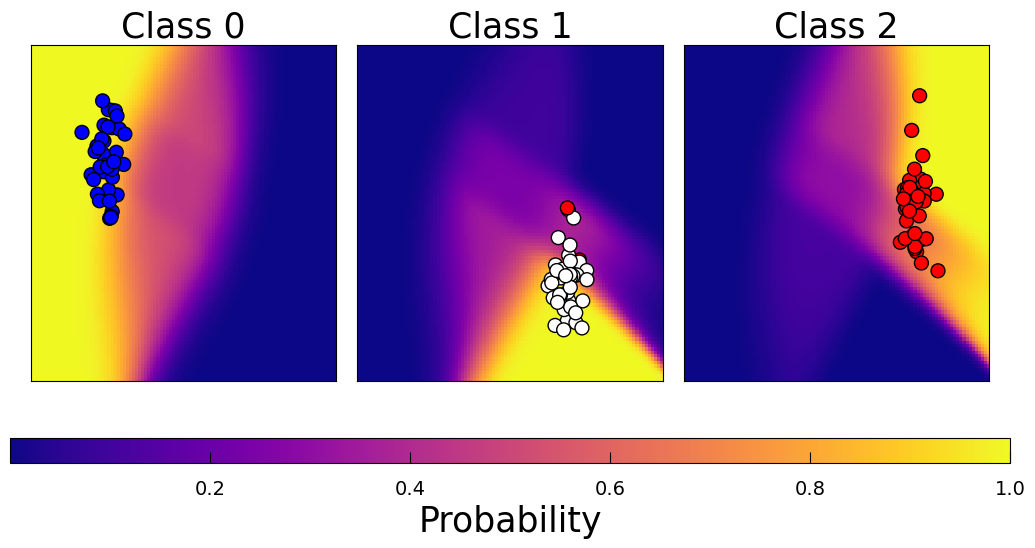

In [124]:
#little regularization but a polynomial kernel of degree 3 this time
contour_SVM(X_3,y_3,c=1,ker='poly',deg=3)

Finally, above we tried a degree 3 polynomial kernel?

### Cancer dataset <a class="anchor" id="SVM-hyperparameters"></a>

In [127]:
scaler = StandardScaler()
scaler.fit(X_cancer_train)
X_cancer_train_scaled = scaler.transform(X_cancer_train)
X_cancer_test_scaled = scaler.transform(X_cancer_test)



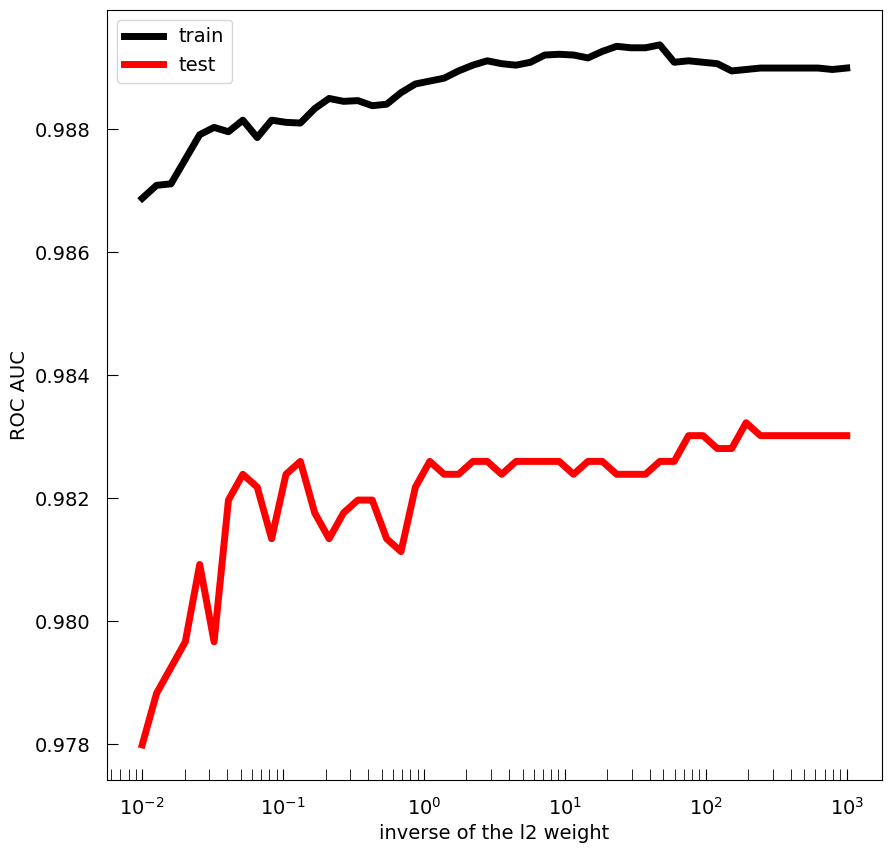

In [128]:
from sklearn.metrics import roc_auc_score
C_range=np.logspace(-2,3,50)


scores_test=[]
scores_train=[]

for k in C_range: 
    SVM_r = svm.SVC(C=k, kernel='linear', 
                    class_weight='balanced', probability=True)
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)

    y_train_prob = SVM_r.predict_proba(X_cancer_train_scaled)
    y_test_prob = SVM_r.predict_proba(X_cancer_test_scaled)

    train_roc_auc_score=roc_auc_score(y_cancer_train,y_train_prob[:, 1])
    test_roc_auc_score=roc_auc_score(y_cancer_test,y_test_prob[:, 1])

    scores_test.append(test_roc_auc_score)
    scores_train.append(train_roc_auc_score)

plt.figure(figsize=(10,10))
plt.xlabel('inverse of the l2 weight')
plt.ylabel('ROC AUC')
plt.plot(C_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(C_range, scores_test,'r-',linewidth=5,label='test')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

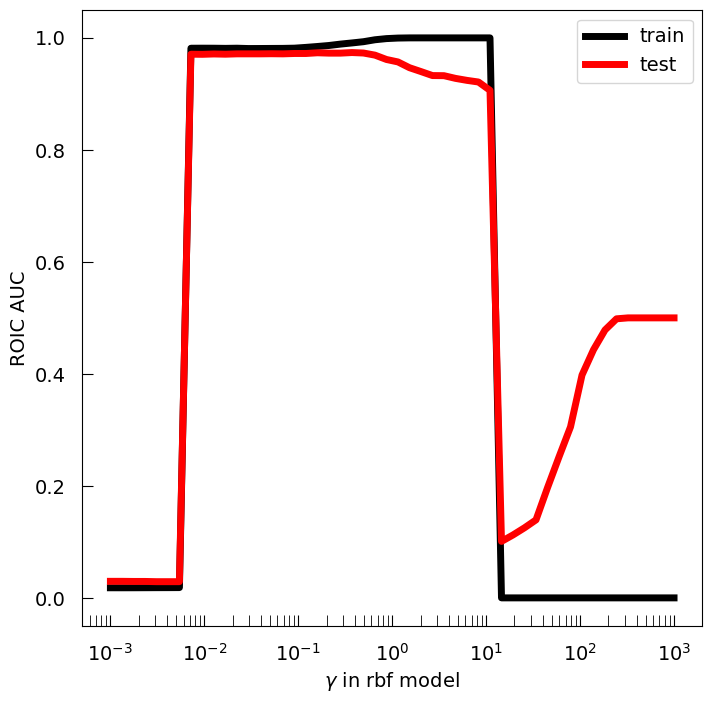

In [129]:
gamma_range=np.logspace(-3,3,50)

scores_test=[]
scores_train=[]

for k in gamma_range: 
    SVM_r = svm.SVC(C=k, kernel='rbf', gamma=k ,
                    class_weight='balanced', probability=True)
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)

    y_train_prob = SVM_r.predict_proba(X_cancer_train_scaled)
    y_test_prob = SVM_r.predict_proba(X_cancer_test_scaled)

    train_roc_auc_score=roc_auc_score(y_cancer_train,y_train_prob[:, 1])
    test_roc_auc_score=roc_auc_score(y_cancer_test,y_test_prob[:, 1])

    scores_test.append(test_roc_auc_score)
    scores_train.append(train_roc_auc_score)
    
plt.figure()
plt.xlabel('$\gamma$ in rbf model')
plt.ylabel('ROIC AUC')
plt.plot(gamma_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(gamma_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.xscale('log')
plt.legend(loc='best')
plt.show()

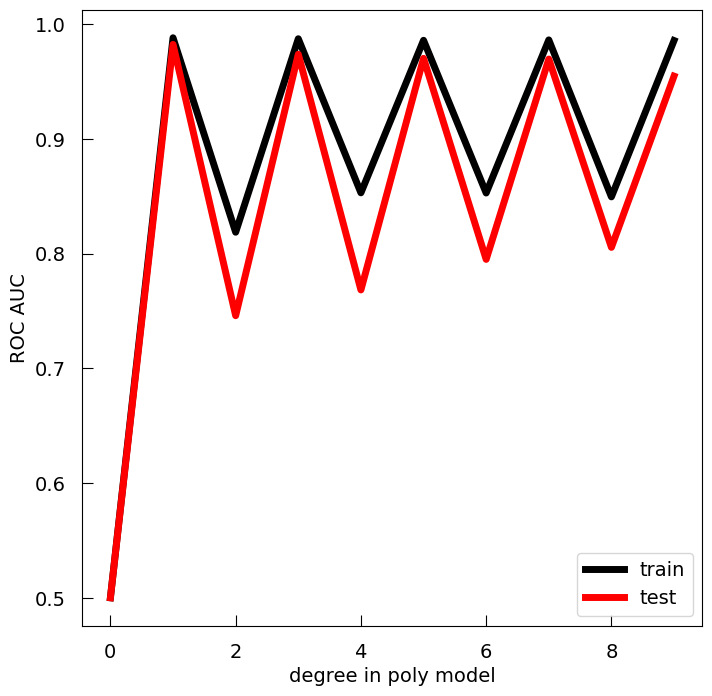

In [130]:
degree_range=np.arange(0,10,1)

scores_test=[]
scores_train=[]

for k in degree_range: 
    SVM_r = svm.SVC(C=1, kernel='poly', degree=k, 
                    probability=True, class_weight='balanced')
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)
    y_train_prob = SVM_r.predict_proba(X_cancer_train_scaled)
    y_test_prob = SVM_r.predict_proba(X_cancer_test_scaled)

    train_roc_auc_score=roc_auc_score(y_cancer_train,y_train_prob[:, 1])
    test_roc_auc_score=roc_auc_score(y_cancer_test,y_test_prob[:, 1])

    scores_test.append(test_roc_auc_score)
    scores_train.append(train_roc_auc_score)

plt.figure()
plt.xlabel('degree in poly model')
plt.ylabel('ROC AUC')
plt.plot(degree_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(degree_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
#plt.xscale('log')
plt.legend(loc='best')
plt.show()

Those 3 hyperparameters show the usual overfitting behaviour when they are increased : monotonous increase of the accuracy on the train function whereas there is a maximum accuracy for the test function after which accuracy decreases with increasing hyperpaprameter value.

If you want to get the weights from the SVM just use `coef_` again but it will only work if you are in the context of a linear SVC.

# String kernels <a class="anchor" id="SVM-kernels"></a>

This paragraph illustrates how to use a SVM kernel not present in sklearn.svm. The following code uses the string kernel from [Hilmarsson et al. BioRxiv, 2021](https://doi.org/10.1101/2021.09.19.460980) in order to classify genomic sequences (here we use toy data based on patterns from real human samples). 

![Figure 2 of Hilmarsson et al. BioRxiv, 2021 : illustration of the string kernel computation](../images/stringKernel.png)

The code is copied from https://github.com/weekend37/string-kernels/blob/master/example.ipynb. More interesting examples can be found in the paper. First let's install the stringkernel package:

In [131]:
#to install string-kernel if that is not already done
!python3 -m pip install string-kernels --upgrade

Let's load the data:

In [132]:
import os 

data_path = "../data"

samples_train = np.load(os.path.join(data_path, "samples_train"+".npy"))
samples_validation = np.load(os.path.join(data_path, "samples_validation"+".npy"))

ancestry_train = np.load(os.path.join(data_path, "ancestry_train"+".npy"))
ancestry_validation = np.load(os.path.join(data_path, "ancestry_validation"+".npy"))

reference = np.load(os.path.join(data_path, "reference"+".npy"))
populations = np.load(os.path.join(data_path, "populations"+".npy"))

print("number of training samples:", len(samples_train))
print("number of validation samples:", len(samples_validation))
print("Sequence length:", len(reference))
print("Number of ancestries:", len(populations))

number of training samples: 552
number of validation samples: 120
Sequence length: 1000
Number of ancestries: 6


The data matrix consists of arrays of nucleotides (rows), where each columns corresponds to a sequence position and each row to a sample.

In [133]:
samples_train

array([['T', 'T', 'A', ..., 'T', 'G', 'G'],
       ['T', 'T', 'A', ..., 'T', 'G', 'G'],
       ['T', 'A', 'A', ..., 'T', 'G', 'G'],
       ...,
       ['T', 'A', 'A', ..., 'T', 'C', 'G'],
       ['A', 'T', 'T', ..., 'T', 'G', 'G'],
       ['A', 'T', 'T', ..., 'T', 'G', 'G']], dtype='<U1')

To use the standart SVM with RBF we need to turn the sequences into numeric values. For this example, we just store the information whether the sequences are the same (0) or different (1) from the reference sequence.

In [134]:
X_train = (samples_train != reference).astype(int)
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]])

The labels are balanced:

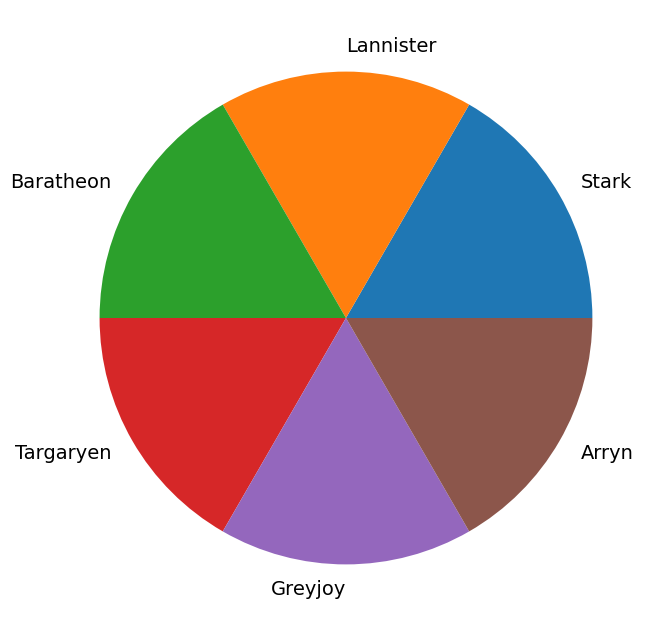

array(['Arryn', 'Baratheon', 'Greyjoy', 'Lannister', 'Stark', 'Targaryen'],
      dtype='<U9')

In [135]:
from stringkernels.utils import plot_label_distribution

plot_label_distribution(ancestry_train)
np.unique(ancestry_train)

The labels need to be turned into numbers in order to use the SVC class with RBF kernel:

In [136]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(ancestry_train)
y_train = le.transform(ancestry_train)
np.unique(y_train)

array([0, 1, 2, 3, 4, 5])

In [137]:
X_val = (samples_validation != reference).astype(int)
y_val = le.transform(ancestry_validation)

In [138]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svm_model = svm.SVC(kernel='rbf')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_val)
svm_accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy: {}%".format(np.round(svm_accuracy*100, 2)))


Validation Accuracy: 59.17%


To use SVC with the string kernel we encountered in the lecture, we do not need the make the features numeric, but we can pass the string as character arrays directly:

In [139]:
from stringkernels.kernels import string_kernel

svm_sk_model = svm.SVC(kernel=string_kernel())
svm_sk_model.fit(samples_train, y_train)
y_pred = svm_sk_model.predict(samples_validation)
svm_sk_accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy: {}%".format(np.round(svm_sk_accuracy*100, 2)))

Validation Accuracy: 69.17%


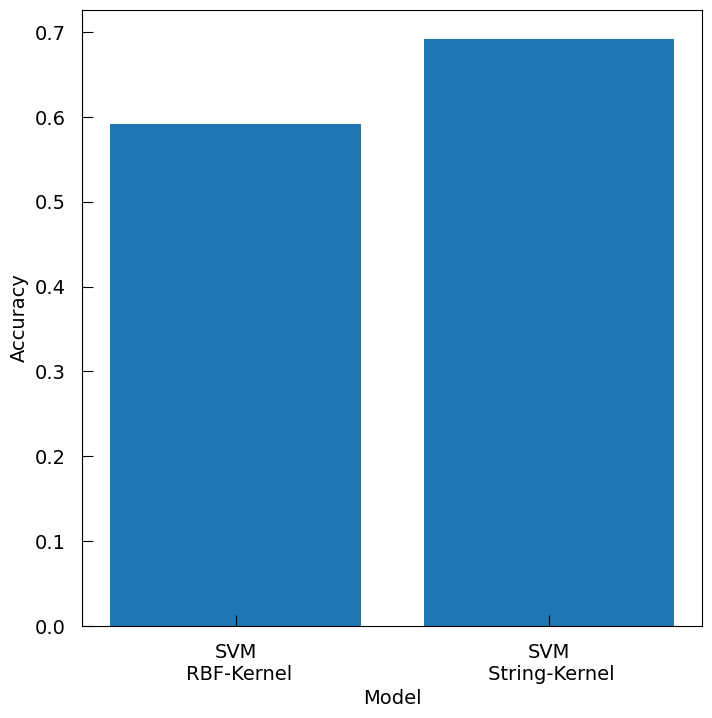

In [140]:
from stringkernels.utils import plot_accuracies

plot_accuracies({
    "SVM\n RBF-Kernel": svm_accuracy,
    "SVM\n String-Kernel": svm_sk_accuracy,
})

[Back to the ToC](#toc)

# Exercise <a class="anchor" id="exo"></a>


Using either the **cancer or the penguin dataset** compare and find the 'best' classifier. What do you learn from those classifiers? 

Don't forget that you have also seen stuff about preprocessing.

Don't go too crazy as it can be time consuming: limit the number of parameter values you are testing for.

**Hint :** before, your grid_param was a dictionnary, and it was specific to a particular model since parameters are model dependant. 
To adapt to multiple models, make a list of `grid_params` where each instance of the list is a dictionnary of parameters specific to the model, you want to try.
*Example:*
``` python
grid_param = [
                {"classifier": [KNeighborsClassifier()],
                 "classifier__n_neighbors": np.arange(1,30,1),
                 },
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2','l1'],
                 }]
```

**Additionnal question** : How would you work with your PCA data and incorporate it to your model?

*Hint:* 
 * Don't forget that PCA needs a centering and a scaling step...
 * Adding PCA can be quite time consuming too. Try a small number of pca components first with other hyperparameters centered around what you found before!


In [74]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


## PENGUIN CORRECTION

setup the pipeline and fit it :

In [256]:
# %load -r -24 solutions/solution_02_penguin.py

reporting best model:

In [143]:
# %load -r 25- solutions/solution_02_penguin.py

## CANCER CORRECTION 

build and fit the pipeline:

In [257]:
# %load -r -26 solutions/solution_02_cancer.py

report the best model:

In [258]:
# %load -r 28-45 solutions/solution_02_cancer.py

plot a roc curve:

In [259]:
# %load -r 46-47 solutions/solution_02_cancer.py

**Alternative with PCA:**

In [260]:
# %load -r 51-89 solutions/solution_02_cancer.py

In [148]:
# %load -r 90-104 solutions/solution_02_cancer.py

In [149]:
# %load -r 106- solutions/solution_02_cancer.py